# Iris Data Generation

# Index

1. [Libraries](#Libraries)
2. [Data Preparation](#Getting-Started)
3. [Exploring Architectures](#GAN-vs-VAE)
4. [Generating Syntethic Data](#Conditional-Generative-Adversarial-Network)
5. [Making the model shiny](#Fine-Tuning-the-CGAN)

## Libraries

In [1]:
import sys
import os

import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import skew, kurtosis, iqr

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchmetrics

import random
from tqdm.auto import tqdm

Seed function for reproducibility.

In [2]:
def set_seed(seed = 0):
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [3]:
project_path = os.path.abspath("..")

if project_path not in sys.path:
    sys.path.append(project_path)

import utils

## Getting Started
The iris dataset will be used to validate the tabular data generation protocol, which despite its apparent simplicity may harbor pitfalls.

In [4]:
X, y = load_iris()['data'], load_iris()['target']
features, species = load_iris()['feature_names'], load_iris()['target_names']

real_iris = pd.DataFrame(X, columns = features)
real_iris['target'] = y
real_iris['target'] = real_iris['target'].map({i: species[i] for i in range(len(species))})
real_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Let's deep dive into our real data.

In [5]:
utils.describe_data(real_iris, 'target')

REAL                     
                       setosa versicolor virginica
MEAN sepal length (cm)  5.006      5.936     6.588
     sepal width (cm)   3.428      2.770     2.974
     petal length (cm)  1.462      4.260     5.552
     petal width (cm)   0.246      1.326     2.026
STD  sepal length (cm)  0.352      0.516     0.636
     sepal width (cm)   0.379      0.314     0.322
     petal length (cm)  0.174      0.470     0.552
     petal width (cm)   0.105      0.198     0.275
MIN  sepal length (cm)  4.300      4.900     4.900
     sepal width (cm)   2.300      2.000     2.200
     petal length (cm)  1.000      3.000     4.500
     petal width (cm)   0.100      1.000     1.400
MAX  sepal length (cm)  5.800      7.000     7.900
     sepal width (cm)   4.400      3.400     3.800
     petal length (cm)  1.900      5.100     6.900
     petal width (cm)   0.600      1.800     2.500
SKEW sepal length (cm)  0.116      0.102     0.114
     sepal width (cm)   0.040     -0.352     0.355
     petal length (cm)  0.103     -0.588     0.533
     petal width (cm)   1.216     -0.030    -0.126
KURT sepal length (cm) -0.346     -0.599    -0.088
     sepal width (cm)   0.744     -0.448     0.520
     petal length (cm)  0.805     -0.074    -0.256
     petal width (cm)   1.434     -0.488    -0.661
IQR  sepal length (cm)  0.400      0.700     0.675
     sepal width (cm)   0.475      0.475     0.375
     petal length (cm)  0.175      0.600     0.775
     petal width (cm)   0.100      0.300     0.500

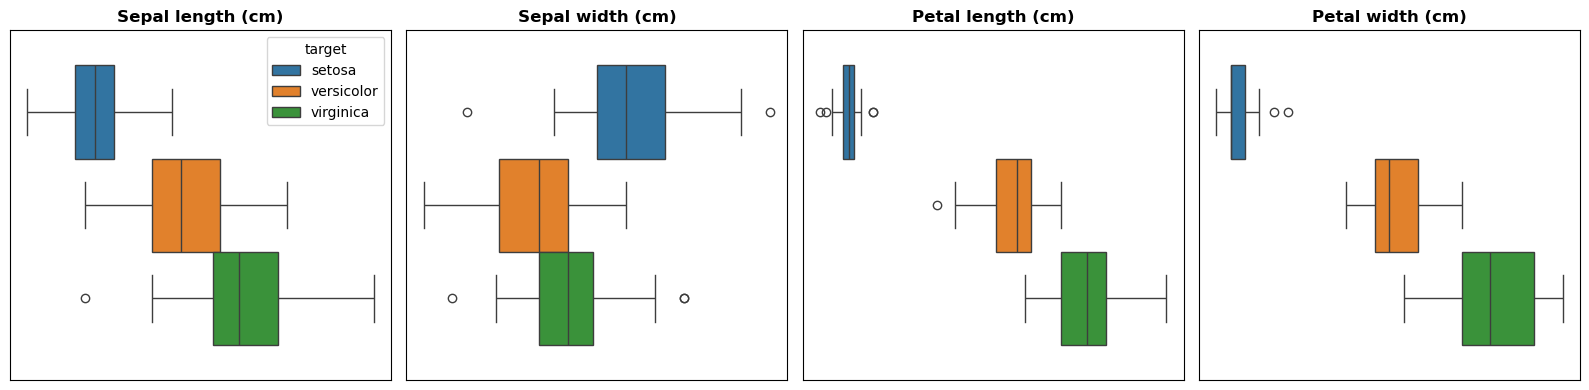

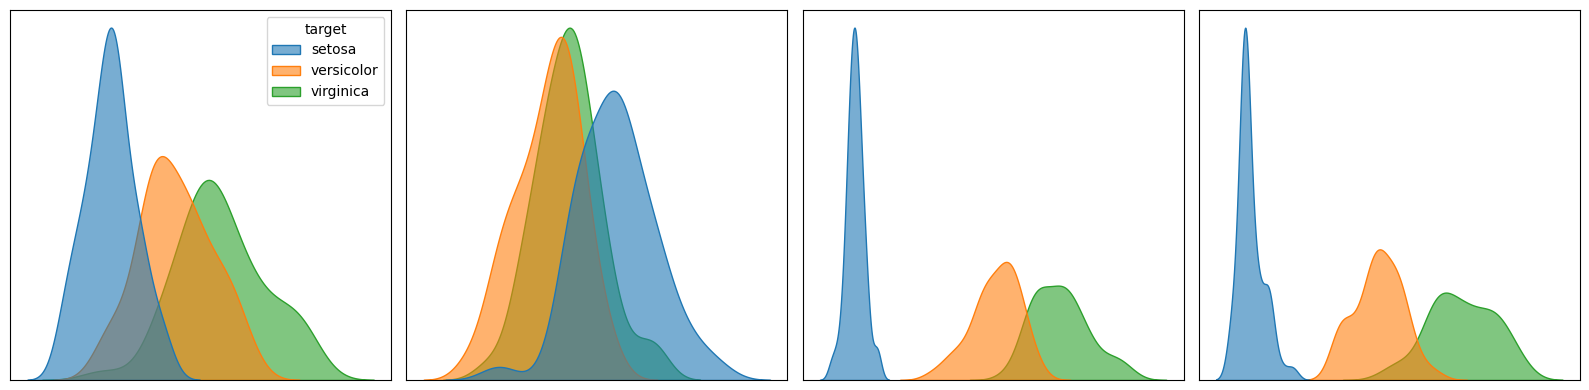

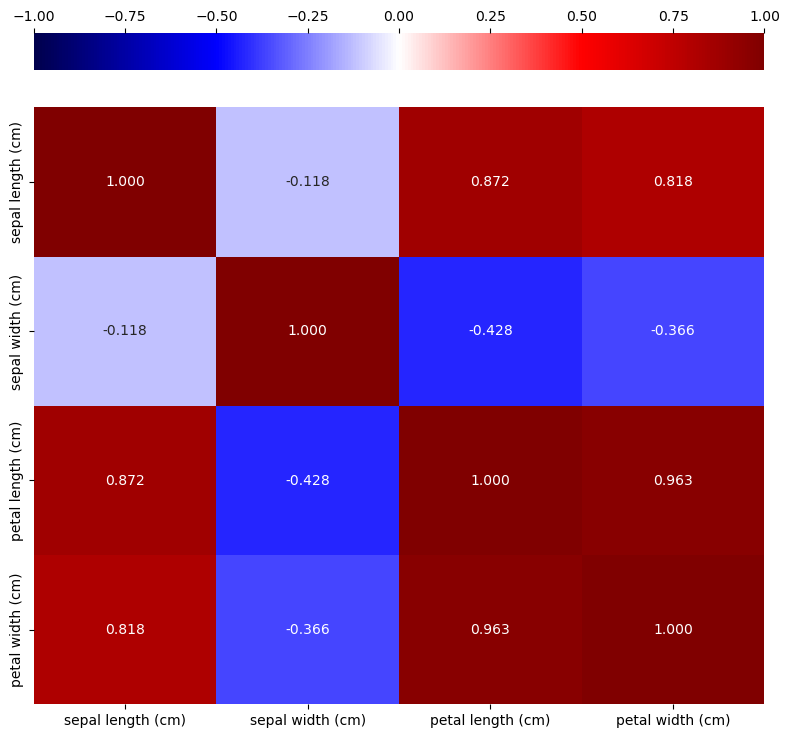

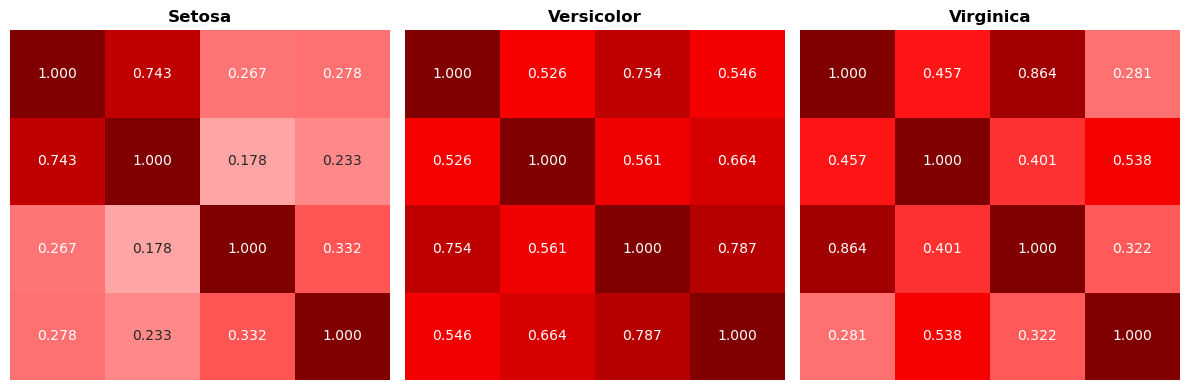

In [6]:
utils.plot_data(real_iris, 'target')

Throughout the notebook we will make comparisons between two datasets, one real and one synthetic; the following dataset, generated by adding normal noise to the real one, is used to introduce the comparison functions.

In [7]:
df = real_iris.select_dtypes('number') + np.random.normal(0, 1, (150,4))
df['target'] = real_iris['target']
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,4.868448,4.009986,1.507444,-1.458981,setosa
1,5.529141,2.232642,0.633756,-1.375763,setosa
2,4.039619,2.060580,2.008202,2.290127,setosa
3,4.692432,5.146071,2.217640,1.234769,setosa
4,4.710071,3.221232,2.667648,0.612591,setosa


Let's start with comparisons! 

First of all a simply comparison between descriptives.

In [8]:
utils.describe_data(real_iris, 'target', df)

REAL                      SYNTHETIC             \
                       setosa versicolor virginica    setosa versicolor   
MEAN sepal length (cm)  5.006      5.936     6.588     5.032      5.644   
     sepal width (cm)   3.428      2.770     2.974     3.325      2.610   
     petal length (cm)  1.462      4.260     5.552     1.123      4.228   
     petal width (cm)   0.246      1.326     2.026     0.603      1.161   
STD  sepal length (cm)  0.352      0.516     0.636     1.232      1.085   
     sepal width (cm)   0.379      0.314     0.322     1.146      1.107   
     petal length (cm)  0.174      0.470     0.552     1.029      1.024   
     petal width (cm)   0.105      0.198     0.275     1.089      1.112   
MIN  sepal length (cm)  4.300      4.900     4.900     1.600      3.533   
     sepal width (cm)   2.300      2.000     2.200     1.215      0.207   
     petal length (cm)  1.000      3.000     4.500    -1.626      1.855   
     petal width (cm)   0.100      1.000     1.400    -1.891     -1.973   
MAX  sepal length (cm)  5.800      7.000     7.900     7.425      7.934   
     sepal width (cm)   4.400      3.400     3.800     6.343      5.484   
     petal length (cm)  1.900      5.100     6.900     2.840      6.603   
     petal width (cm)   0.600      1.800     2.500     2.557      3.368   
SKEW sepal length (cm)  0.116      0.102     0.114    -0.174      0.182   
     sepal width (cm)   0.040     -0.352     0.355     0.407     -0.072   
     petal length (cm)  0.103     -0.588     0.533    -0.562     -0.007   
     petal width (cm)   1.216     -0.030    -0.126    -0.183     -0.445   
KURT sepal length (cm) -0.346     -0.599    -0.088    -0.150     -0.564   
     sepal width (cm)   0.744     -0.448     0.520    -0.099      0.019   
     petal length (cm)  0.805     -0.074    -0.256     0.111      0.183   
     petal width (cm)   1.434     -0.488    -0.661    -0.482      0.388   
IQR  sepal length (cm)  0.400      0.700     0.675     1.826      1.323   
     sepal width (cm)   0.475      0.475     0.375     1.453      1.522   
     petal length (cm)  0.175      0.600     0.775     1.392      1.167   
     petal width (cm)   0.100      0.300     0.500     1.396      1.460   

                                  
                       virginica  
MEAN sepal length (cm)     6.644  
     sepal width (cm)      2.980  
     petal length (cm)     5.440  
     petal width (cm)      2.233  
STD  sepal length (cm)     1.261  
     sepal width (cm)      1.200  
     petal length (cm)     1.026  
     petal width (cm)      1.046  
MIN  sepal length (cm)     3.630  
     sepal width (cm)      1.011  
     petal length (cm)     2.941  
     petal width (cm)      0.119  
MAX  sepal length (cm)     8.811  
     sepal width (cm)      5.831  
     petal length (cm)     7.570  
     petal width (cm)      5.022  
SKEW sepal length (cm)    -0.414  
     sepal width (cm)      0.412  
     petal length (cm)     0.020  
     petal width (cm)      0.434  
KURT sepal length (cm)    -0.397  
     sepal width (cm)     -0.576  
     petal length (cm)    -0.257  
     petal width (cm)      0.180  
IQR  sepal length (cm)     1.764  
     sepal width (cm)      1.641  
     petal length (cm)     1.479  
     petal width (cm)      1.391

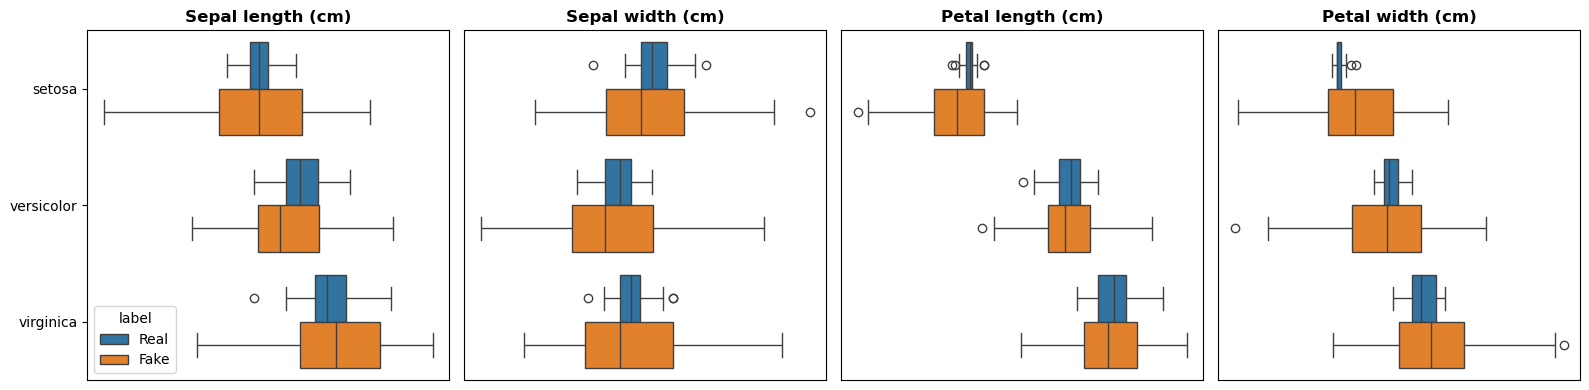

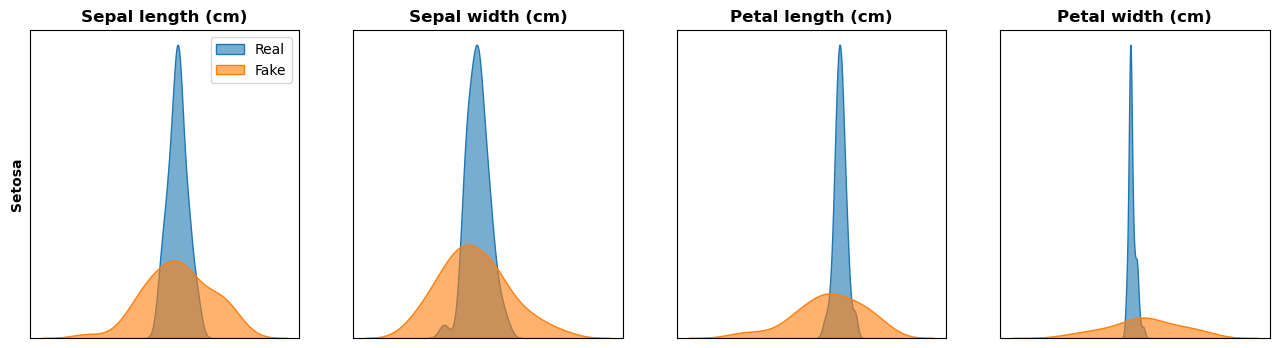

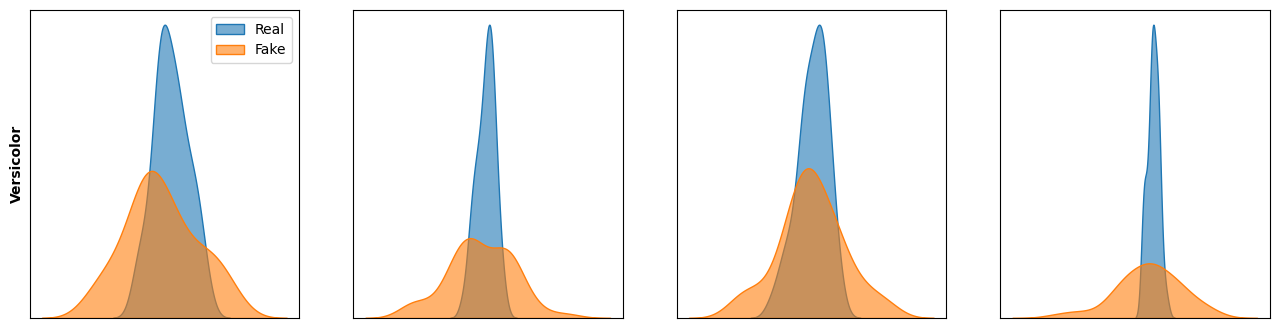

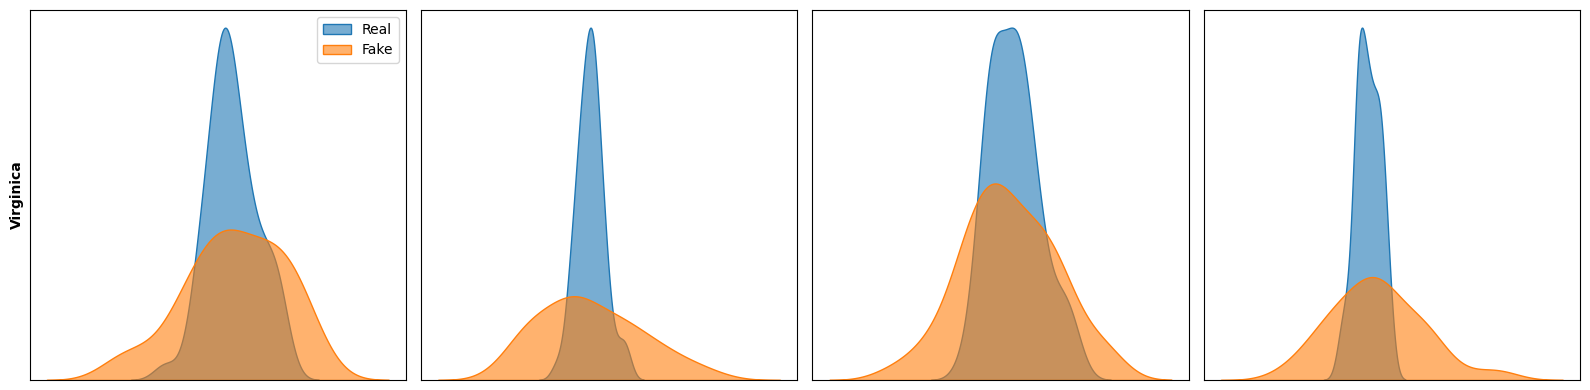

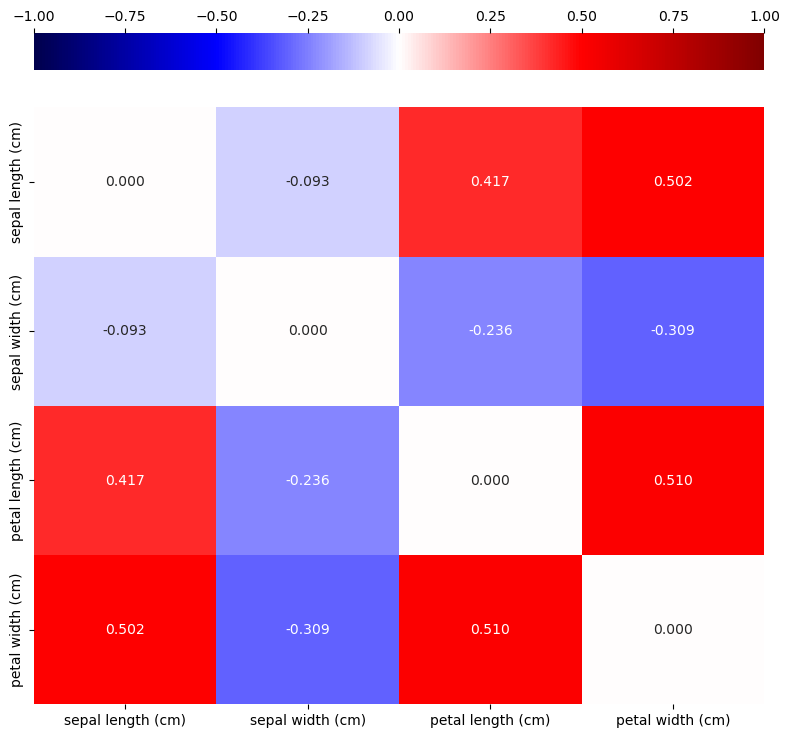

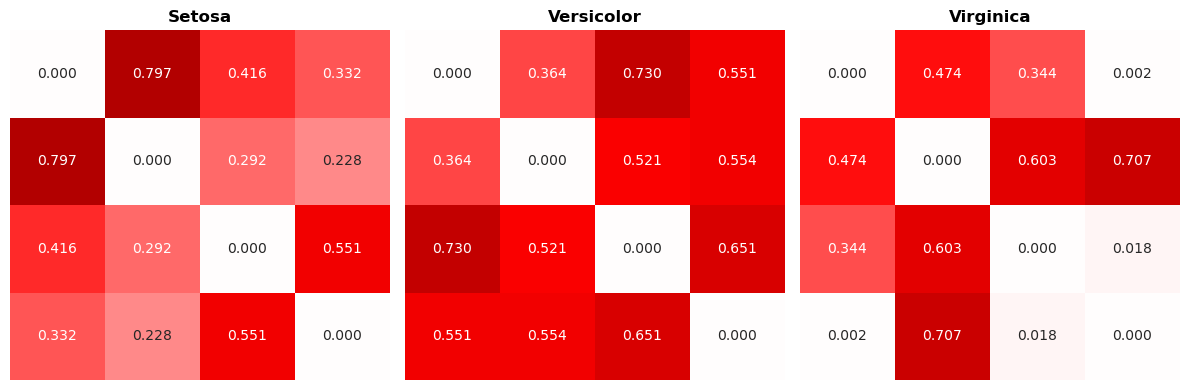

In [9]:
utils.plot_data(real_iris, 'target', df)

Throughout the work, the goal will be to minimize the differences, numerical and graphical, between the actual and synthetic data. Two different architectures will be used to achieve this goal: the Variational Auto Encoder **(VAE)** and the Generative Adversarial Network **(GAN)**, and the one that will show the best performance for the same task complexity and resources will be selected.

## GAN vs VAE

Both valid, the two approaches show different challenges and advantages:

1. **Variational Auto Encoder**:

Pros:
- Easy to train
- We can look inside the neaural network "Black Box"

Cons:

- Less coverage of variability
- Assumption of data normality

2. **Generative Adversarial Network**:

Pros:
- More realistic generated data
- Flexibility with respect to actual data distributions

Cons:
- Hard to train (model collapse, lot of resources, lot of data)
- Lower interpretability

The performance of the two architectures will be analyzed using them in as simple a version as possible. The next step will then be to prepare the data for modeling.

In [10]:
std_scl = StandardScaler()
X_scld = std_scl.fit_transform(X)

ohe = OneHotEncoder(sparse_output = False)
y_ohe = ohe.fit_transform(y.reshape(-1,1))

Preparing Torch Dataset and Dataloader

In [11]:
class IrisDataset(Dataset):
    def __init__(self, data, target):
        self.data = torch.tensor(data, dtype = torch.float32)
        self.label = torch.tensor(target, dtype = torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]
    
real_vae_dataset = IrisDataset(X_scld, y_ohe)
real_vae_dataloader = DataLoader(real_vae_dataset, batch_size = 32, shuffle = True)

real_gan_dataset = IrisDataset(X_scld, y)
real_gan_dataloader = DataLoader(real_gan_dataset, batch_size = 32, shuffle = True)

for dataloader in [real_vae_dataloader, real_gan_dataloader]:
    for batch in dataloader:
        print(f'Data shape: {batch[0].shape}, labels shape: {batch[1].shape}')
        break

Data shape: torch.Size([32, 4]), labels shape: torch.Size([32, 3])
Data shape: torch.Size([32, 4]), labels shape: torch.Size([32])


Let's build baseline models, starting with the Conditional VAE

In [12]:
class ConditionalVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, condition_dim):
        super(ConditionalVAE, self).__init__()
        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + condition_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
        )
        
        self.fc_mu = nn.Linear(16, latent_dim)
        self.fc_logvar = nn.Linear(16, latent_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + condition_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim),
            nn.Tanh()
        )
        
    def encode(self, x, c):
        x_cond = torch.cat([x, c], dim=1)
        h = self.encoder(x_cond)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        z_cond = torch.cat([z, c], dim=1)
        return self.decoder(z_cond)

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, c)
        return recon_x, mu, logvar
    
set_seed()
vae = ConditionalVAE(input_dim = 4, latent_dim = 4, condition_dim = 3)

for batch in real_vae_dataloader:
    vae_batch = batch
    break
    
vae_out = vae(vae_batch[0], vae_batch[1])
for out in vae_out:
    print(f'Shape: {out.shape}')

Shape: torch.Size([32, 4])
Shape: torch.Size([32, 4])
Shape: torch.Size([32, 4])


Now let's build the GANs net.

In [13]:
class Generator(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 4),
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x
    
class Discriminator(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
            
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x

set_seed()    
gen = Generator(input_dim = 4, num_classes = 3)
disc = Discriminator(input_dim = 4, num_classes = 3)

for batch in real_gan_dataloader:
    gan_batch = batch
    break
    
print(f'Generator output shape: {gen(torch.randn(32, 4), gan_batch[1]).shape}')
print(f'Discriminator output shape: {disc(gan_batch[0], gan_batch[1]).shape}')

Generator output shape: torch.Size([32, 4])
Discriminator output shape: torch.Size([32, 1])


Let's check models' size in parameters.

In [14]:
print(f'VAE has {sum(p.numel() for p in vae.parameters())} parameters')
print(f'Gen has {sum(p.numel() for p in gen.parameters())} parameters')
print(f'Disc has {sum(p.numel() for p in disc.parameters())} parameters')

VAE has 1724 parameters
Gen has 861 parameters
Disc has 810 parameters


Models have approximately the same number of parameters.

We can now train the simpliest Conditional VAE.

In [15]:
vae_opt = torch.optim.Adam(vae.parameters(), lr = 1e-3)

def vae_loss(reconstructed, original, mu, logvar, beta=1.0):
    recon_loss = F.mse_loss(reconstructed, original, reduction='mean')
    
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl_div /= original.size(0)

    total_loss = recon_loss + beta * kl_div
    return total_loss, recon_loss, kl_div

set_seed()
z = torch.randn(150, 4)

In [16]:
for epoch in tqdm(range(1, 501), desc = 'Training VAE'):
    
    vae.train()
    epoch_loss = 0
    
    for data, label in real_vae_dataloader:
        
        reconstructed, mu, logvar = vae(data, label)
        loss, recon_loss, kl_div = vae_loss(reconstructed, data, mu, logvar)
        
        vae_opt.zero_grad()
        loss.backward()
        vae_opt.step()
        
        epoch_loss += loss.item()
        
    epoch_total_loss = epoch_loss/len(real_vae_dataloader)
    
    if epoch % 100 == 0 or epoch == 50:
        
        print(f'\nEpoch {epoch}/500 | Loss: {epoch_total_loss:.4f}')
        with torch.no_grad():
            vae.eval()
            vae_z = vae(z, real_vae_dataloader.dataset.label)[0]
            utils.compare_results(real_vae_dataloader.dataset.data, vae_z)

Training VAE:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 50/500 | Loss: 0.3227
MEAN: [-0.017  0.008 -0.08  -0.051]
STD:  [0.283 0.434 0.225 0.253]
MIN:  [-0.897 -1.855 -0.581 -0.465]
MAX:  [1.615 2.23  0.845 0.815]
SKEW: [ 0.647 -0.348  0.128  0.281]
KURT: [0.931 1.651 0.12  0.177]

Epoch 100/500 | Loss: 0.2992
MEAN: [-0.002  0.003 -0.072 -0.032]
STD:  [0.233 0.374 0.194 0.207]
MIN:  [-0.886 -1.741 -0.572 -0.453]
MAX:  [1.535 2.182 0.8   0.733]
SKEW: [ 0.473 -0.185  0.048  0.104]
KURT: [0.938 1.675 0.115 0.176]

Epoch 200/500 | Loss: 0.2913
MEAN: [-0.01  -0.001 -0.09  -0.051]
STD:  [0.224 0.368 0.182 0.19 ]
MIN:  [-0.877 -1.709 -0.568 -0.448]
MAX:  [1.538 2.174 0.797 0.722]
SKEW: [ 0.505 -0.103  0.089  0.129]
KURT: [0.929 1.672 0.111 0.171]

Epoch 300/500 | Loss: 0.2944
MEAN: [-0.013 -0.007 -0.089 -0.05 ]
STD:  [0.219 0.364 0.179 0.185]
MIN:  [-0.877 -1.717 -0.568 -0.448]
MAX:  [1.541 2.193 0.793 0.718]
SKEW: [ 0.499 -0.089  0.064  0.1  ]
KURT: [0.928 1.676 0.107 0.168]

Epoch 400/500 | Loss: 0.2872
MEAN: [-0.005 -0.006 -0.088 -0.052]

In [17]:
vae_df = pd.DataFrame(std_scl.inverse_transform(vae_z.detach().numpy()))
vae_df['target'] = y
vae_df['target'] = vae_df['target'].map({i: species[i] for i in range(len(species))})
vae_df.columns = real_iris.columns

Let's train the Conditional GAN.

In [18]:
g_opt = torch.optim.Adam(gen.parameters(), lr = 1e-3)
d_opt = torch.optim.Adam(disc.parameters(), lr = 1e-3)

criterion = nn.BCELoss()

set_seed()
z = torch.randn(150, 4)

In [19]:
for epoch in tqdm(range(501), desc = 'Training Conditional GAN'):
    
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    
    disc.train()
    gen.train()
    
    for data, labels in real_gan_dataloader:
        
        real_data = data
        real_labels = torch.ones(real_data.shape[0], 1)
        
        train_z = torch.randn(real_data.shape[0], 4)
        fake_data = gen(train_z, labels)
        fake_labels = torch.zeros(real_data.shape[0], 1)
        
        disc.zero_grad()
        
        real_loss = criterion(disc(real_data, labels), real_labels)
        fake_loss = criterion(disc(fake_data.detach(), labels), fake_labels)
        d_loss = (real_loss + fake_loss) / 2
        disc_epoch_loss += d_loss.item()
        d_loss.backward()
        
        d_opt.step()
        
        gen.zero_grad()
        
        gen_labels = torch.ones(real_data.shape[0], 1)
        
        g_loss = criterion(disc(fake_data, labels), gen_labels)
        gen_epoch_loss += g_loss.item()
        g_loss.backward()
        
        g_opt.step()
        
    g_epoch_loss = gen_epoch_loss/len(real_gan_dataloader)
    d_epoch_loss = disc_epoch_loss/len(real_gan_dataloader)
    
    if epoch % 100 == 0 or epoch == 500:
        
        print(f'\nEpoch {epoch}/500 | DLoss: {d_epoch_loss:.4f} | GLoss {g_epoch_loss:.4f}')
        with torch.no_grad():
            gen.eval()
            gen_z = gen(z, real_gan_dataloader.dataset.label)
            utils.compare_results(real_gan_dataloader.dataset.data, gen_z)

Training Conditional GAN:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 0/500 | DLoss: 0.7049 | GLoss 0.8255
MEAN: [ 0.033 -0.012 -0.096 -0.011]
STD:  [0.965 0.964 0.969 0.935]
MIN:  [-1.721 -2.333 -1.584 -1.283]
MAX:  [2.438 2.961 1.563 1.514]
SKEW: [ 0.531 -0.075 -0.764 -0.276]
KURT: [-0.946 -0.561 -2.841 -0.99 ]

Epoch 100/500 | DLoss: 0.6766 | GLoss 0.7381
MEAN: [ 1.178  0.847  0.444 -0.09 ]
STD:  [0.281 0.398 0.118 0.102]
MIN:  [ 1.076 -0.597  0.278 -0.11 ]
MAX:  [2.856 2.985 0.897 0.211]
SKEW: [ 0.985 -0.152  0.035  0.228]
KURT: [0.48  1.558 0.045 0.088]

Epoch 200/500 | DLoss: 0.7312 | GLoss 0.6434
MEAN: [ 0.032 -0.386 -0.037 -0.121]
STD:  [ 0.147  0.315  0.119 -0.063]
MIN:  [-0.763 -1.7   -0.207 -0.03 ]
MAX:  [ 1.062  1.716  0.37  -0.073]
SKEW: [-0.217  0.858 -0.129 -0.168]
KURT: [0.87  1.638 0.069 0.152]

Epoch 300/500 | DLoss: 0.6807 | GLoss 0.7064
MEAN: [ 0.41  -0.046 -0.049 -0.151]
STD:  [0.234 0.235 0.136 0.043]
MIN:  [-0.19  -1.107 -0.176 -0.094]
MAX:  [1.713 1.681 0.518 0.068]
SKEW: [ 0.584 -0.189  0.305  0.292]
KURT: [0.878 1.544 0.0

In [20]:
gan_df = pd.DataFrame(std_scl.inverse_transform(gen_z.detach().numpy()))
gan_df['target'] = y
gan_df['target'] = gan_df['target'].map({i: species[i] for i in range(len(species))})
gan_df.columns = real_iris.columns

Let's check which of the two results better approximates the actual data using the Kolmogorov-Smirnov test and the Wasserstein Distance.

In [21]:
print(f"KS test for VAE Data:\n{round(utils.calculate_ks_test(real_iris, vae_df), 5)}\n")
print(f"KS test for GAN Data:\n{round(utils.calculate_ks_test(real_iris, gan_df), 5)}\n")

print(f"WD for VAE Data:\n{round(utils.calculate_wasserstein_distance(real_iris, vae_df), 5)}\n")
print(f"WD for GAN Data:\n{round(utils.calculate_wasserstein_distance(real_iris, gan_df), 5)}")

KS test for VAE Data:
             Feature  KS Statistic  P-Value
0  sepal length (cm)       0.21333  0.00211
1   sepal width (cm)       0.28000  0.00001
2  petal length (cm)       0.33333  0.00000
3   petal width (cm)       0.32000  0.00000

KS test for GAN Data:
             Feature  KS Statistic  P-Value
0  sepal length (cm)       0.28667  0.00001
1   sepal width (cm)       0.29333  0.00000
2  petal length (cm)       0.33333  0.00000
3   petal width (cm)       0.32000  0.00000

WD for VAE Data:
             Feature  W Distance
0  sepal length (cm)     0.25957
1   sepal width (cm)     0.15692
2  petal length (cm)     0.41564
3   petal width (cm)     0.17683

WD for GAN Data:
             Feature  W Distance
0  sepal length (cm)     0.29182
1   sepal width (cm)     0.15968
2  petal length (cm)     0.63601
3   petal width (cm)     0.20348


As much as all the distances found using the KS test are significant (we have to reject H0 and so the distributions are not from the same population) these appear to be smaller overall for the VAE data. Even when examining Wasserstein's distances, the VAE seems to track the original distributions better. Let's check the Q-Q plots.

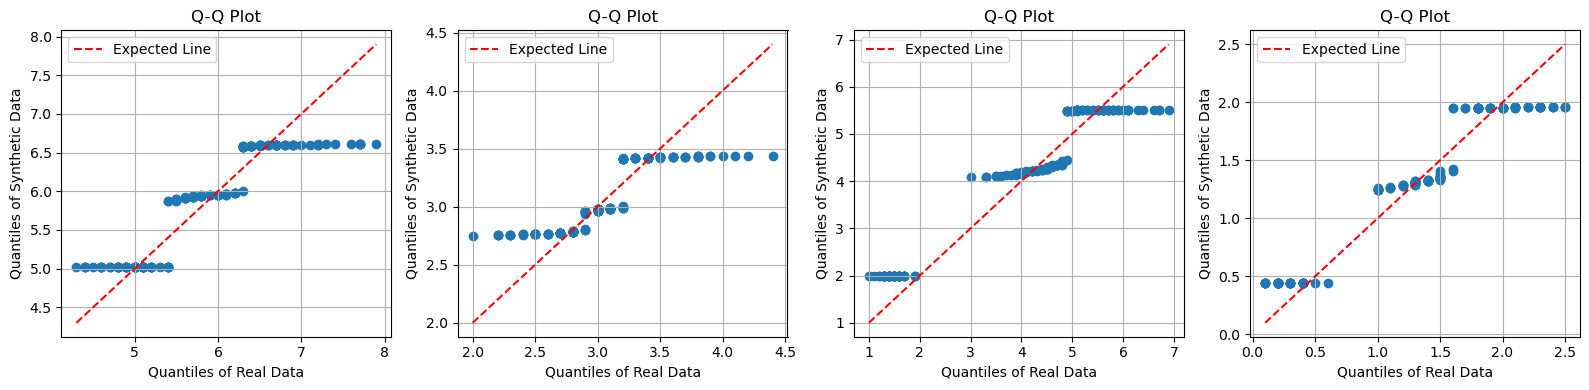

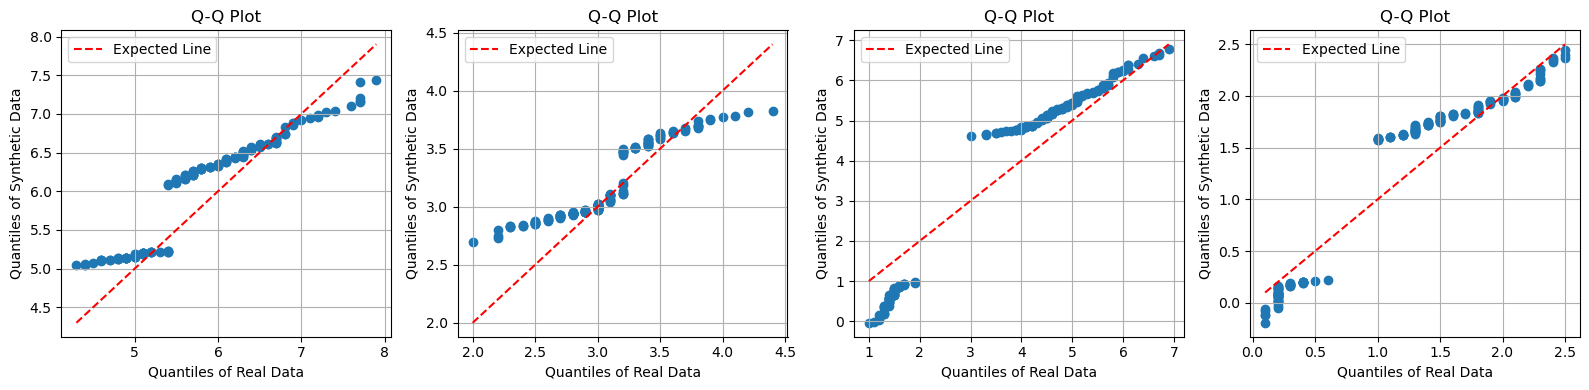

In [22]:
utils.plot_quantiles(real_iris, vae_df)
utils.plot_quantiles(real_iris, gan_df)

Examining the Q-Q plots there is slightly more overlap for the GAN-generated data. We will examine the data visually to make the final decision.

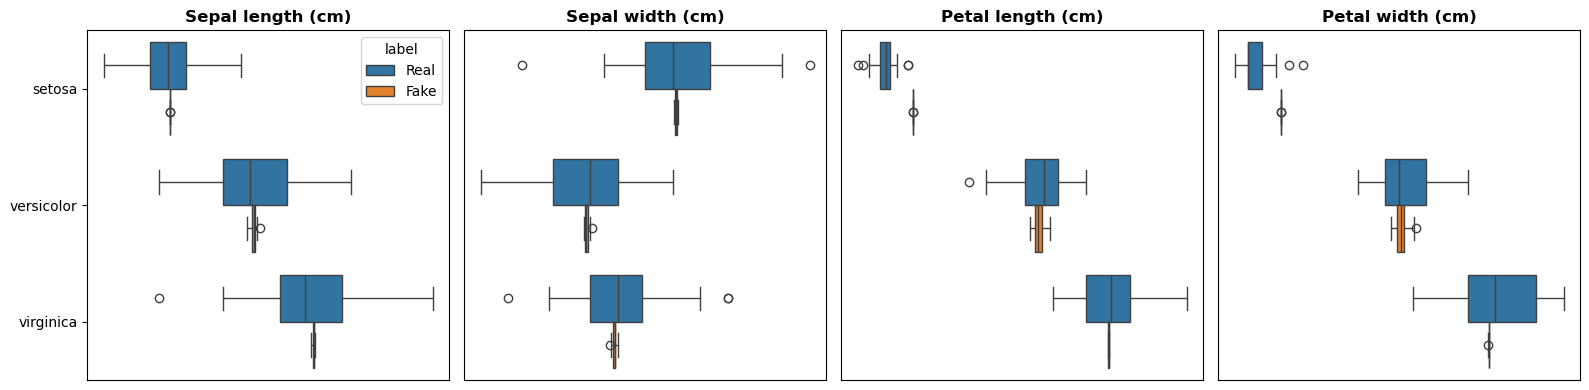

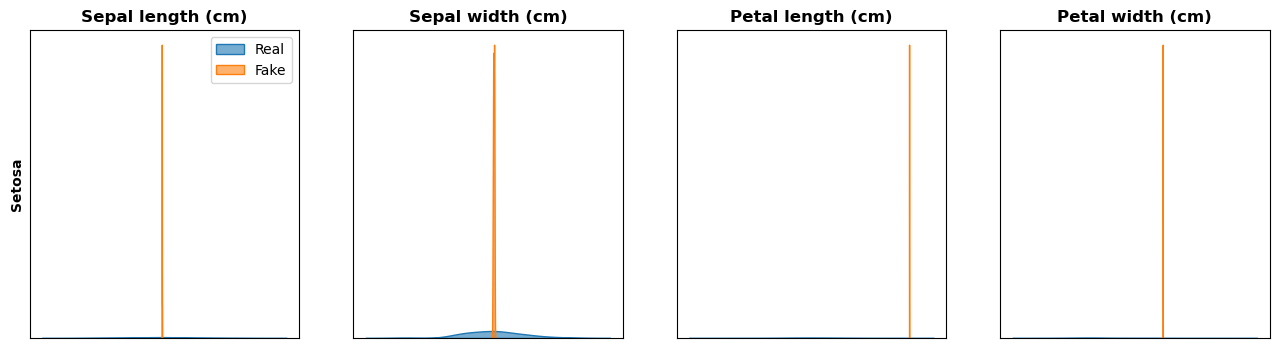

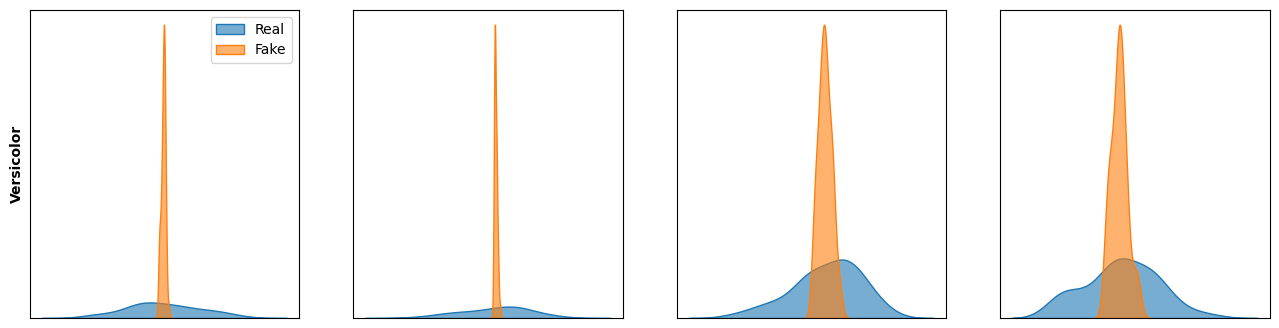

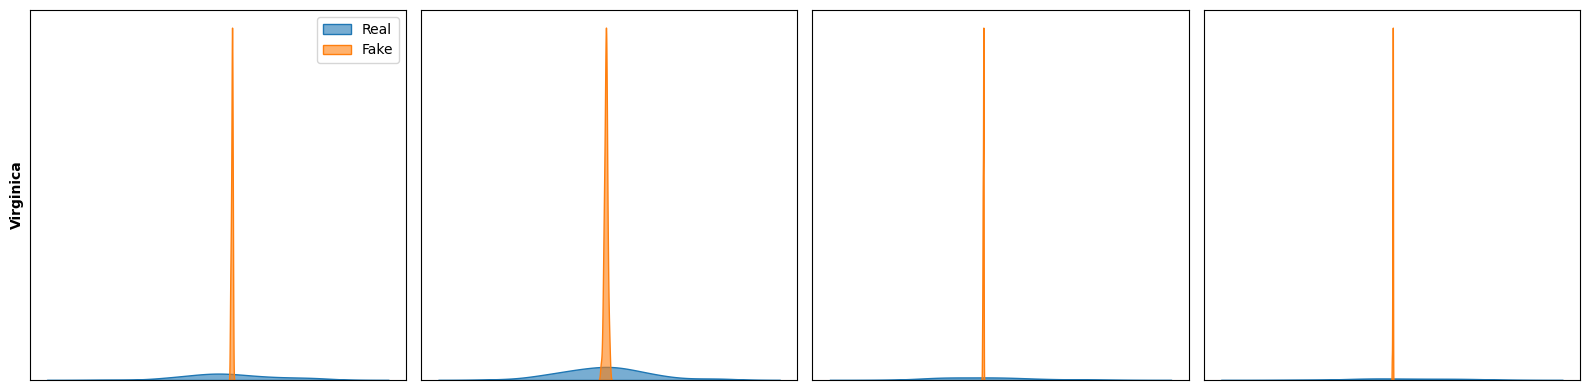

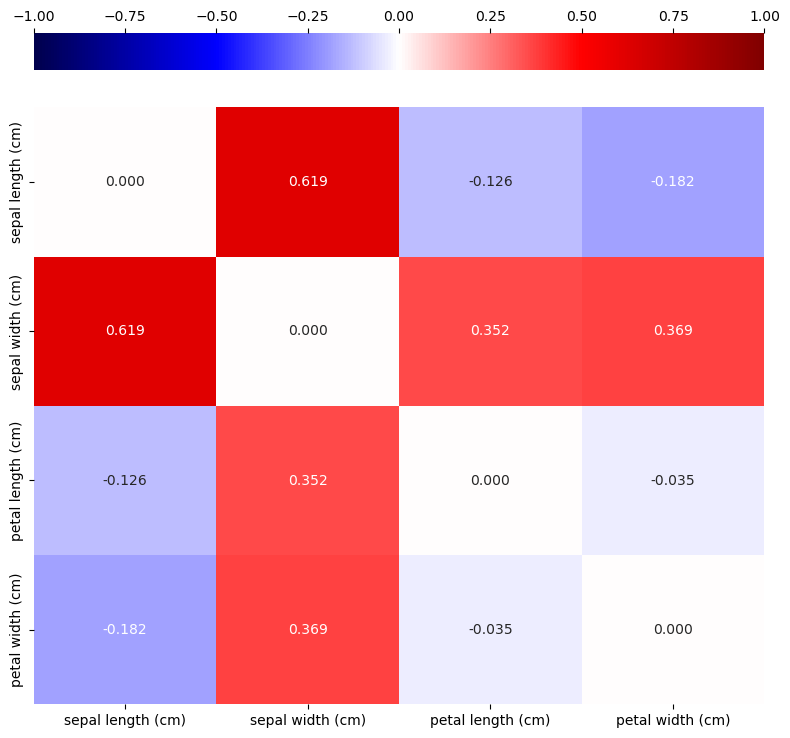

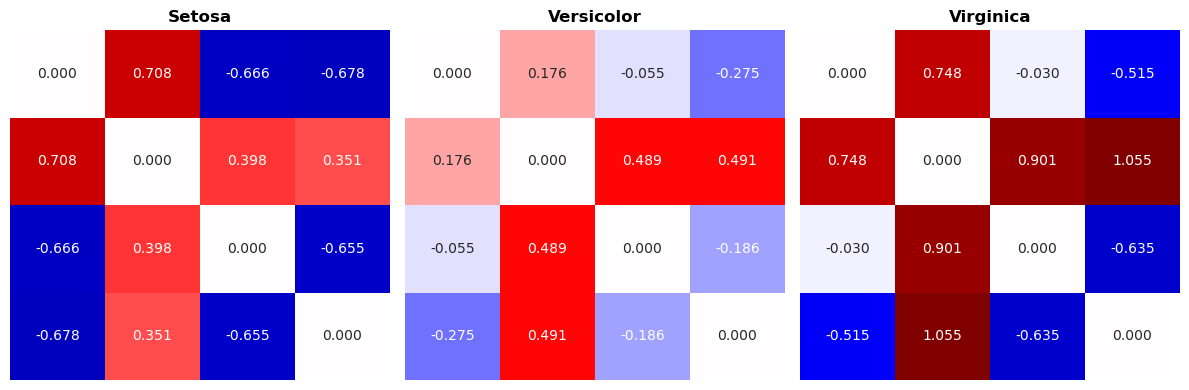

In [23]:
utils.plot_data(real_iris, 'target', vae_df)

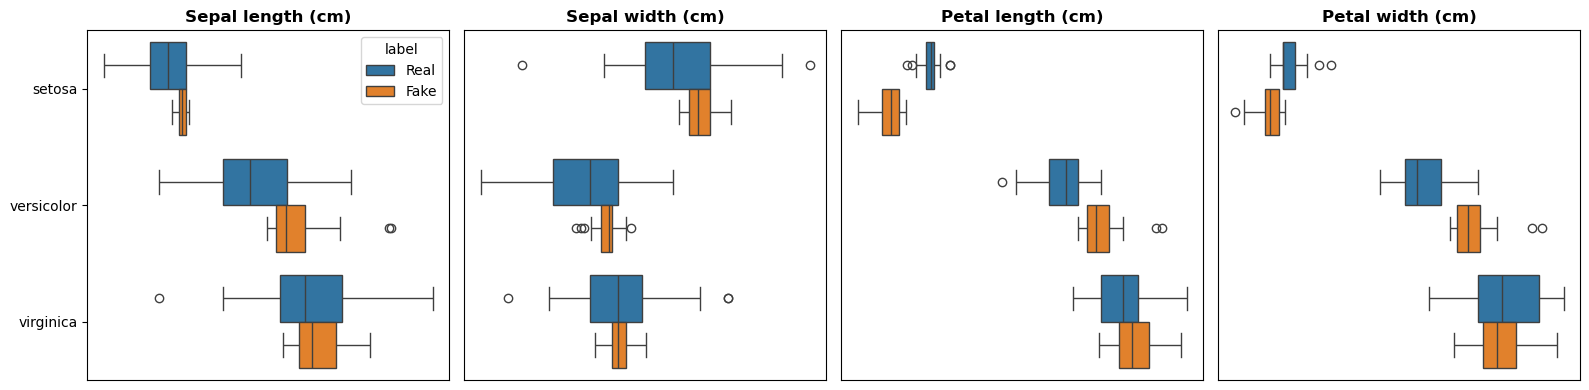

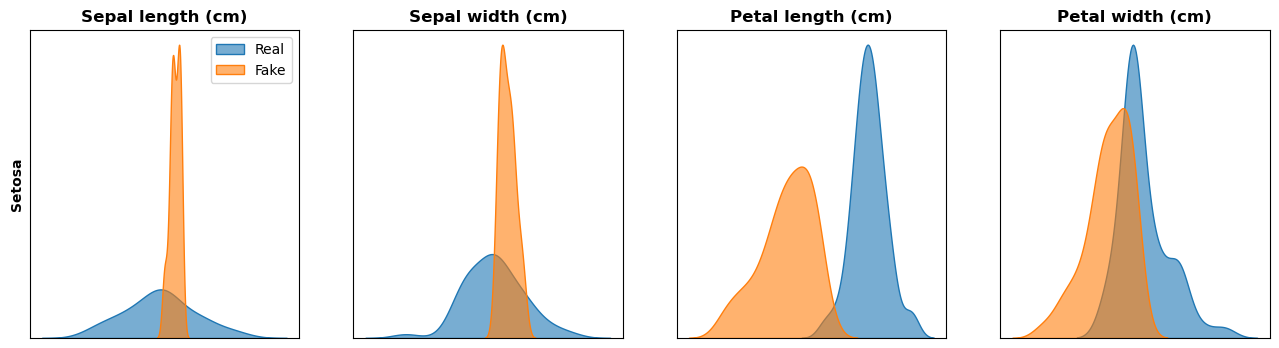

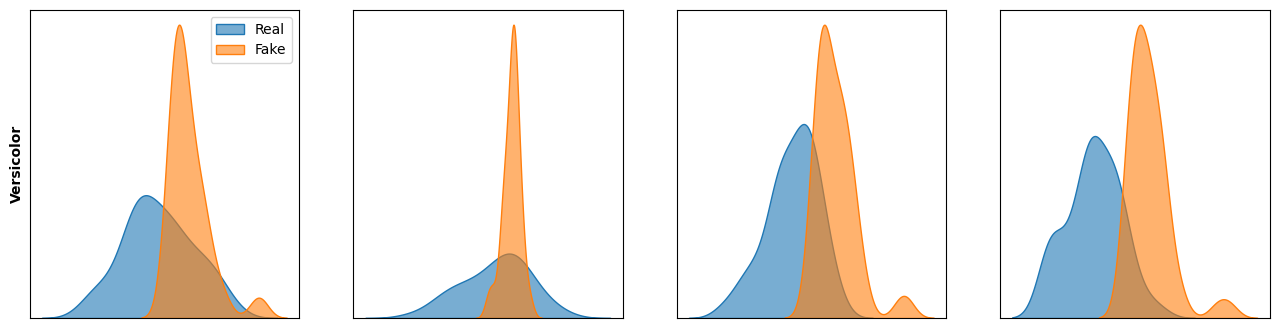

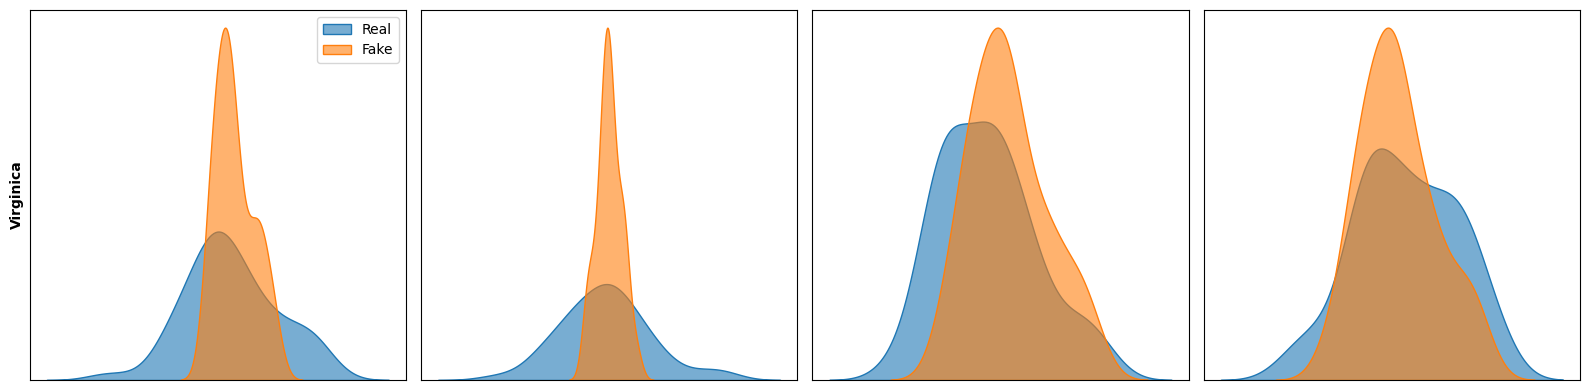

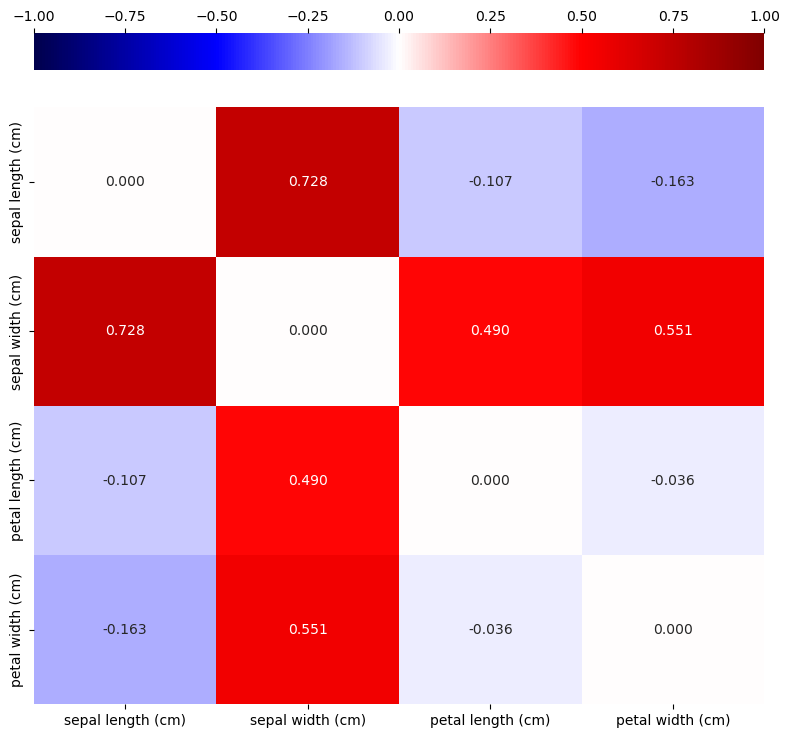

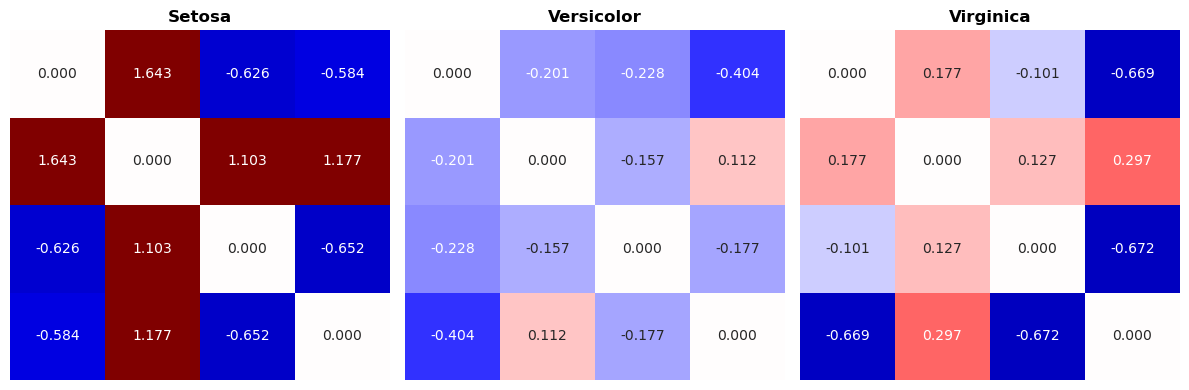

In [24]:
utils.plot_data(real_iris, 'target', gan_df)

As much as it can still be improved GAN seems to be the most suitable architecture for replicating data so the focus of the next steps will be on finding the best architecture.

## Conditional Generative Adversarial Network

In this section, we focus on refining the GAN architecture to maximize its performance in generating synthetic data that closely resembles the real dataset. Our aim is to improve the overlap between the distributions of generated and real data while maintaining computational efficiency. The resulting model will form the basis for subsequent evaluations and applications.

The strating point is a model with 861 parameters. We'll build other 2 bigger versions to prove out which is the best.

In [25]:
# Smallest GAN

class Generator1(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 4),
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x
    
class Discriminator1(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
            
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x

# Medium GAN

class Generator2(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 4),
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x
    
class Discriminator2(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
            
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x

# Big GAN

class Generator3(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 4),
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x
    
class Discriminator3(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
            
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x
    
set_seed()    
small_gan_gen = Generator1(input_dim = 4, num_classes = 3)
small_gan_disc = Discriminator1(input_dim = 4, num_classes = 3)

med_gan_gen = Generator2(input_dim = 4, num_classes = 3)
med_gan_disc = Discriminator2(input_dim = 4, num_classes = 3)

big_gan_gen = Generator3(input_dim = 4, num_classes = 3)
big_gan_disc = Discriminator3(input_dim = 4, num_classes = 3)

small_gan = {'Generator':small_gan_gen, 'Discriminator':small_gan_disc}

med_gan = {'Generator':med_gan_gen, 'Discriminator':med_gan_disc}

big_gan = {'Generator':big_gan_gen, 'Discriminator':big_gan_disc}

In [26]:
for size in [small_gan, med_gan, big_gan]:
    for model in size:
        print(f'{model} parameters: {sum(p.numel() for p in size[model].parameters())/1000}k')

Generator parameters: 0.861k
Discriminator parameters: 0.81k
Generator parameters: 3.197k
Discriminator parameters: 3.146k
Generator parameters: 11.965k
Discriminator parameters: 11.914k


The 3 models have a very different number of parameters. Next step is to set the optimized ones and start training.

In [27]:
small_gan['Generator optimizer'] = torch.optim.Adam(small_gan_gen.parameters(), lr = 1e-3)
small_gan['Discriminator optimizer'] = torch.optim.Adam(small_gan_disc.parameters(), lr = 1e-3)

med_gan['Generator optimizer'] = torch.optim.Adam(med_gan_gen.parameters(), lr = 1e-3)
med_gan['Discriminator optimizer'] = torch.optim.Adam(med_gan_disc.parameters(), lr = 1e-3)

big_gan['Generator optimizer'] = torch.optim.Adam(big_gan_gen.parameters(), lr = 1e-3)
big_gan['Discriminator optimizer'] = torch.optim.Adam(big_gan_disc.parameters(), lr = 1e-3)

criterion = nn.BCELoss()

set_seed()
z = torch.randn(150, 4)

In [28]:
for idx, size in enumerate([small_gan, med_gan, big_gan]):
    
    for epoch in tqdm(range(501), desc = f'Training Conditional GAN {idx + 1}'):
        
        gen = size['Generator']
        disc = size['Discriminator']
        g_opt = size['Generator optimizer']
        d_opt = size['Discriminator optimizer']
        
        gen_epoch_loss = 0
        disc_epoch_loss = 0
    
        disc.train()
        gen.train()
        
        for data, labels in real_gan_dataloader:
            
            real_data = data
            real_labels = torch.ones(real_data.shape[0], 1)
        
            train_z = torch.randn(real_data.shape[0], 4)
            fake_data = gen(train_z, labels)
            fake_labels = torch.zeros(real_data.shape[0], 1)
        
            disc.zero_grad()
            
            real_loss = criterion(disc(real_data, labels), real_labels)
            fake_loss = criterion(disc(fake_data.detach(), labels), fake_labels)
            d_loss = (real_loss + fake_loss) / 2
            disc_epoch_loss += d_loss.item()
            d_loss.backward()
        
            d_opt.step()
        
            gen.zero_grad()
        
            gen_labels = torch.ones(real_data.shape[0], 1)
        
            g_loss = criterion(disc(fake_data, labels), gen_labels)
            gen_epoch_loss += g_loss.item()
            g_loss.backward()
        
            g_opt.step()
            
        g_epoch_loss = gen_epoch_loss/len(real_gan_dataloader)
        d_epoch_loss = disc_epoch_loss/len(real_gan_dataloader)
        
        if epoch % 100 == 0 or epoch == 500:
        
            print(f'\nEpoch {epoch}/500 | DLoss: {d_epoch_loss:.4f} | GLoss {g_epoch_loss:.4f}')
            with torch.no_grad():
                gen.eval()
                gen_z = gen(z, real_gan_dataloader.dataset.label)
                utils.compare_results(real_gan_dataloader.dataset.data, gen_z)

Training Conditional GAN 1:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 0/500 | DLoss: 0.7049 | GLoss 0.8255
MEAN: [ 0.033 -0.012 -0.096 -0.011]
STD:  [0.965 0.964 0.969 0.935]
MIN:  [-1.721 -2.333 -1.584 -1.283]
MAX:  [2.438 2.961 1.563 1.514]
SKEW: [ 0.531 -0.075 -0.764 -0.276]
KURT: [-0.946 -0.561 -2.841 -0.99 ]

Epoch 100/500 | DLoss: 0.6766 | GLoss 0.7381
MEAN: [ 1.178  0.847  0.444 -0.09 ]
STD:  [0.281 0.398 0.118 0.102]
MIN:  [ 1.076 -0.597  0.278 -0.11 ]
MAX:  [2.856 2.985 0.897 0.211]
SKEW: [ 0.985 -0.152  0.035  0.228]
KURT: [0.48  1.558 0.045 0.088]

Epoch 200/500 | DLoss: 0.7312 | GLoss 0.6434
MEAN: [ 0.032 -0.386 -0.037 -0.121]
STD:  [ 0.147  0.315  0.119 -0.063]
MIN:  [-0.763 -1.7   -0.207 -0.03 ]
MAX:  [ 1.062  1.716  0.37  -0.073]
SKEW: [-0.217  0.858 -0.129 -0.168]
KURT: [0.87  1.638 0.069 0.152]

Epoch 300/500 | DLoss: 0.6807 | GLoss 0.7064
MEAN: [ 0.41  -0.046 -0.049 -0.151]
STD:  [0.234 0.235 0.136 0.043]
MIN:  [-0.19  -1.107 -0.176 -0.094]
MAX:  [1.713 1.681 0.518 0.068]
SKEW: [ 0.584 -0.189  0.305  0.292]
KURT: [0.878 1.544 0.0

Training Conditional GAN 2:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 0/500 | DLoss: 0.6951 | GLoss 0.8095
MEAN: [-0.173  0.142 -0.191  0.029]
STD:  [0.972 0.97  0.977 0.962]
MIN:  [-1.981 -2.232 -1.703 -1.272]
MAX:  [2.211 3.183 1.539 1.67 ]
SKEW: [-0.309  0.787  0.186  0.757]
KURT: [-0.94   1.437 -0.69  -2.501]

Epoch 100/500 | DLoss: 0.5758 | GLoss 1.0313
MEAN: [-0.521 -1.036  0.353 -0.13 ]
STD:  [ 0.157  0.191 -0.414  0.143]
MIN:  [-1.272 -2.518  0.957 -0.308]
MAX:  [0.046 0.65  0.032 0.208]
SKEW: [ 0.337 -0.299  0.262  0.413]
KURT: [0.529 1.637 0.063 0.106]

Epoch 200/500 | DLoss: 0.6027 | GLoss 1.4536
MEAN: [-0.095  0.765 -0.056 -0.335]
STD:  [0.773 0.845 0.979 0.742]
MIN:  [-1.658 -1.15  -1.508 -1.498]
MAX:  [1.661 3.51  1.688 0.429]
SKEW: [-0.628  0.293  1.119 -0.934]
KURT: [-0.258  0.19  -4.367 -1.363]

Epoch 300/500 | DLoss: 0.5000 | GLoss 0.9699
MEAN: [ 0.105 -0.514  0.206  0.069]
STD:  [-0.038  0.593 -0.102 -0.032]
MIN:  [-0.282 -2.29   0.242  0.09 ]
MAX:  [1.052 2.041 0.462 0.082]
SKEW: [0.523 0.723 0.089 0.115]
KURT: [0.904 1.655 0.0

Training Conditional GAN 3:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 0/500 | DLoss: 0.6879 | GLoss 0.6823
MEAN: [-0.    -0.247  0.18   0.336]
STD:  [0.989 0.997 0.977 0.982]
MIN:  [-1.844 -2.661 -1.313 -1.037]
MAX:  [2.442 2.829 1.922 2.005]
SKEW: [-0.412  0.768  0.205 -0.053]
KURT: [-0.834 -0.129 -1.165 -1.465]

Epoch 100/500 | DLoss: 0.4969 | GLoss 1.1421
MEAN: [-0.923 -0.247  0.19  -0.696]
STD:  [ 0.228  0.124 -0.331 -0.549]
MIN:  [-2.009 -1.546  0.548 -0.267]
MAX:  [-1.122  1.522 -0.281 -3.067]
SKEW: [-0.735 -0.308  0.182 -0.334]
KURT: [-0.593  1.667  0.058 -0.263]

Epoch 200/500 | DLoss: 0.5317 | GLoss 1.2669
MEAN: [-0.7   -1.711 -0.118  0.245]
STD:  [-0.546  0.32  -0.49   0.239]
MIN:  [-0.491 -2.963  0.495 -0.056]
MAX:  [-0.867  0.161 -0.418  1.005]
SKEW: [0.47  0.934 0.181 0.457]
KURT: [0.883 1.5   0.086 0.148]

Epoch 300/500 | DLoss: 0.5168 | GLoss 0.9491
MEAN: [0.391 0.265 0.224 0.313]
STD:  [0.402 0.072 0.734 0.62 ]
MIN:  [-0.502 -1.142 -0.902 -0.52 ]
MAX:  [2.269 1.929 1.607 1.476]
SKEW: [ 0.97  -0.347  0.018  0.233]
KURT: [ 0.896  1.6

Great! Now we can compare the results to choose the best architecture.

In [29]:
gen1_z = small_gan['Generator'](z, real_gan_dataloader.dataset.label)
gan1_df = pd.DataFrame(std_scl.inverse_transform(gen1_z.detach().numpy()))
gan1_df['target'] = y
gan1_df['target'] = gan1_df['target'].map({i: species[i] for i in range(len(species))})
gan1_df.columns = real_iris.columns

gen2_z = med_gan['Generator'](z, real_gan_dataloader.dataset.label)
gan2_df = pd.DataFrame(std_scl.inverse_transform(gen2_z.detach().numpy()))
gan2_df['target'] = y
gan2_df['target'] = gan2_df['target'].map({i: species[i] for i in range(len(species))})
gan2_df.columns = real_iris.columns

gen3_z = big_gan['Generator'](z, real_gan_dataloader.dataset.label)
gan3_df = pd.DataFrame(std_scl.inverse_transform(gen3_z.detach().numpy()))
gan3_df['target'] = y
gan3_df['target'] = gan3_df['target'].map({i: species[i] for i in range(len(species))})
gan3_df.columns = real_iris.columns

In [30]:
for idx, data in enumerate([gan1_df, gan2_df, gan3_df]):
    print(f"GAN {idx + 1} KS test:\n{round(utils.calculate_ks_test(real_iris, data), 5)}\n")
    
for idx, data in enumerate([gan1_df, gan2_df, gan3_df]):
    print(f"GAN {idx + 1} WD:\n{round(utils.calculate_wasserstein_distance(real_iris, data), 5)}\n")    

GAN 1 KS test:
             Feature  KS Statistic  P-Value
0  sepal length (cm)       0.28667  0.00001
1   sepal width (cm)       0.29333  0.00000
2  petal length (cm)       0.33333  0.00000
3   petal width (cm)       0.32000  0.00000

GAN 2 KS test:
             Feature  KS Statistic  P-Value
0  sepal length (cm)       0.27333  0.00002
1   sepal width (cm)       0.20000  0.00486
2  petal length (cm)       0.22667  0.00086
3   petal width (cm)       0.33333  0.00000

GAN 3 KS test:
             Feature  KS Statistic  P-Value
0  sepal length (cm)       0.20000  0.00486
1   sepal width (cm)       0.16667  0.03084
2  petal length (cm)       0.22000  0.00136
3   petal width (cm)       0.24000  0.00033

GAN 1 WD:
             Feature  W Distance
0  sepal length (cm)     0.29182
1   sepal width (cm)     0.15968
2  petal length (cm)     0.63601
3   petal width (cm)     0.20348

GAN 2 WD:
             Feature  W Distance
0  sepal length (cm)     0.30485
1   sepal width (cm)     0.11643
2  peta

The architecture with the most parameters **(11.965k)** seems to be the best according to both metrics.

Let's verify it with the Q-Q plots.

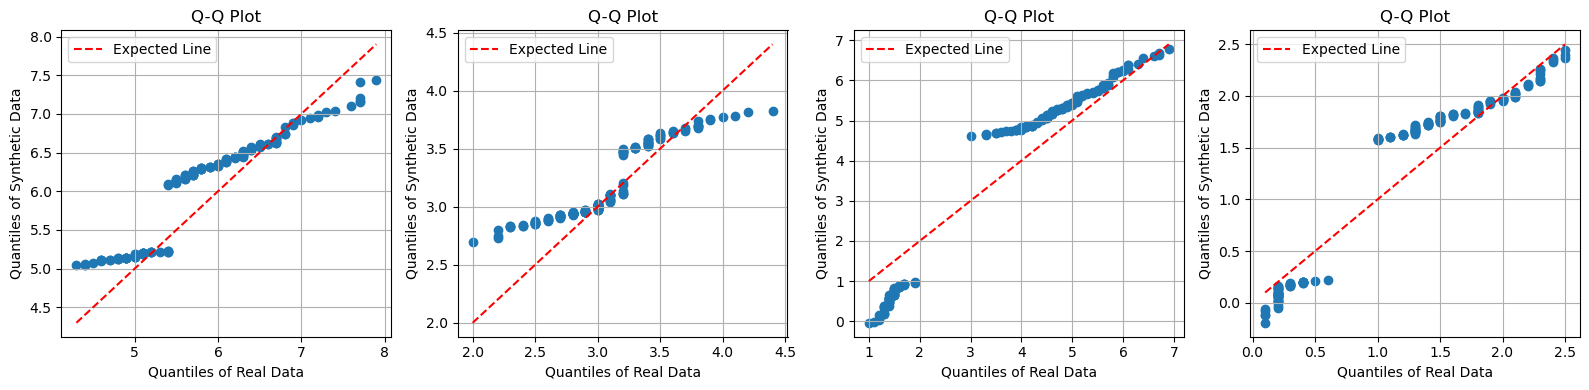

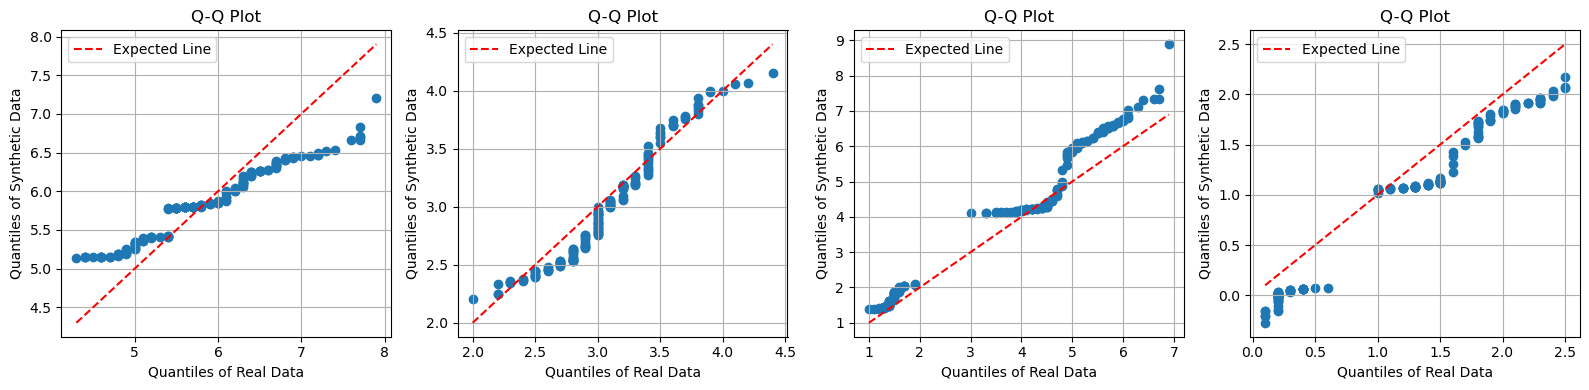

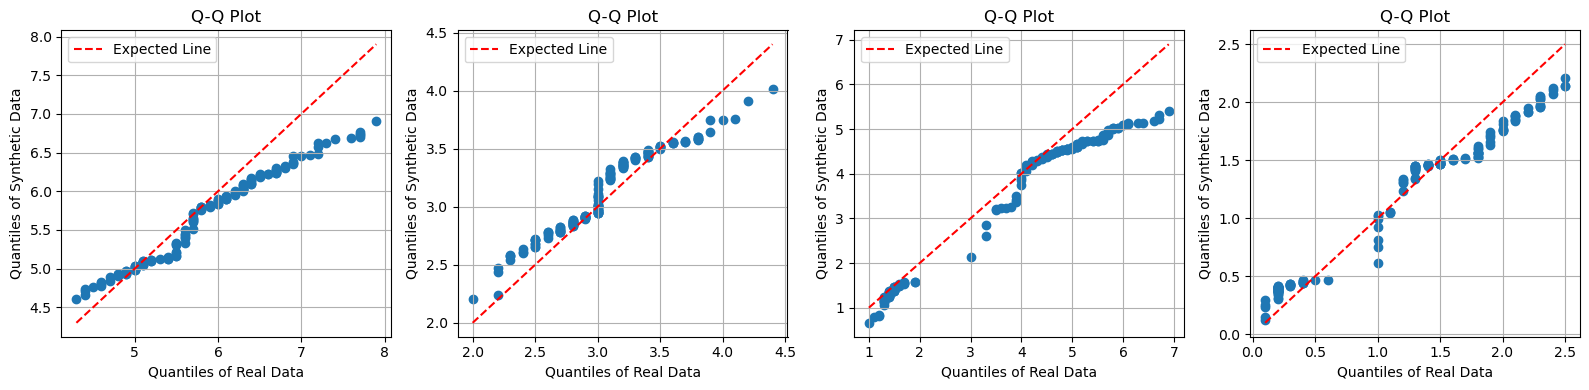

In [31]:
utils.plot_quantiles(real_iris, gan1_df)
utils.plot_quantiles(real_iris, gan2_df)
utils.plot_quantiles(real_iris, gan3_df)

Overall, for the same noise vector size, it is the bigger model that shows the best performance: in fact, it produces the smallest differences between the observed and recreated distributions and in the Q-Q graphs it can be seen that the two distributions tend to overlap more than in the other two models.

We will continue with the fine-tuning of this architecture. But first we will look for the best dimension of the noise vector.

In [32]:
noise_size = [2**n for n in range(1, 7)]

noise_vector_model_dict = {'Noise Vector Size':[], 'Gen state dict': []}

for size_idx, size in enumerate(noise_size):
    
    set_seed()
    gen = Generator3(input_dim = size, num_classes = 3)
    disc = Discriminator3(input_dim = 4, num_classes = 3)
    
    g_opt = torch.optim.Adam(gen.parameters(), lr = 1e-3)
    d_opt = torch.optim.Adam(disc.parameters(), lr = 1e-3)

    criterion = nn.BCELoss()
    
    for epoch in tqdm(range(501), desc = f'Training with {size} noise vector'):
    
        gen_epoch_loss = 0
        disc_epoch_loss = 0

        disc.train()
        gen.train()
        
        for data, labels in real_gan_dataloader:
            real_data = data
            real_labels = torch.ones(real_data.shape[0], 1)
            
            set_seed()
            train_z = torch.randn(real_data.shape[0], size)
            fake_data = gen(train_z, labels)
            fake_labels = torch.zeros(real_data.shape[0], 1)
        
            disc.zero_grad()
            
            real_loss = criterion(disc(real_data, labels), real_labels)
            fake_loss = criterion(disc(fake_data.detach(), labels), fake_labels)
            d_loss = (real_loss + fake_loss) / 2
            disc_epoch_loss += d_loss.item()
            d_loss.backward()
            
            d_opt.step()
        
            gen.zero_grad()

            gen_labels = torch.ones(real_data.shape[0], 1)

            g_loss = criterion(disc(fake_data, labels), gen_labels)
            gen_epoch_loss += g_loss.item()
            g_loss.backward()

            g_opt.step()
            
        g_epoch_loss = gen_epoch_loss/len(real_gan_dataloader)
        d_epoch_loss = disc_epoch_loss/len(real_gan_dataloader)
    
    noise_vector_model_dict['Noise Vector Size'].append(size)
    noise_vector_model_dict['Gen state dict'].append(gen.state_dict())

Training with 2 noise vector:   0%|          | 0/501 [00:00<?, ?it/s]

Training with 4 noise vector:   0%|          | 0/501 [00:00<?, ?it/s]

Training with 8 noise vector:   0%|          | 0/501 [00:00<?, ?it/s]

Training with 16 noise vector:   0%|          | 0/501 [00:00<?, ?it/s]

Training with 32 noise vector:   0%|          | 0/501 [00:00<?, ?it/s]

Training with 64 noise vector:   0%|          | 0/501 [00:00<?, ?it/s]

Great! Let's create new data!

In [33]:
data_dict = {'dataframe':[]}

for idx, size in enumerate(noise_vector_model_dict['Noise Vector Size']):
    gen = Generator3(input_dim = size, num_classes = 3)
    gen.load_state_dict(noise_vector_model_dict['Gen state dict'][idx])
    
    set_seed()
    z = torch.randn(150, size)
    
    generated_data = gen(z, real_gan_dataloader.dataset.label)
    fake_df = pd.DataFrame(std_scl.inverse_transform(generated_data.detach().numpy()))
    fake_df['target'] = y
    fake_df['target'] = fake_df['target'].map({i: species[i] for i in range(len(species))})
    fake_df.columns = real_iris.columns
    
    data_dict['dataframe'].append(fake_df)

In [34]:
ks_results_df = []

for i, dataframe in enumerate(data_dict['dataframe']):
    ks_results = utils.calculate_ks_test(real_iris, dataframe)
    ks_statistics = ks_results['KS Statistic']
    ks_results_df.append({'Model': f'Model {2**(i+1)} NV GAN', **ks_statistics})

comparison_df = pd.DataFrame(ks_results_df).set_index('Model')
comparison_df.columns = real_iris.columns[:-1]
comparison_df['avg_ks'] = comparison_df.mean(1)
comparison_df.style.background_gradient(cmap = 'Reds')

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),avg_ks
Model,,,,,
Model 2 NV GAN,0.200000,0.193333,0.260000,0.200000,0.213333
Model 4 NV GAN,0.293333,0.400000,0.313333,0.266667,0.318333
Model 8 NV GAN,0.240000,0.426667,0.293333,0.193333,0.288333
Model 16 NV GAN,0.260000,0.246667,0.240000,0.180000,0.231667
Model 32 NV GAN,0.340000,0.353333,0.106667,0.220000,0.255000
Model 64 NV GAN,0.226667,0.280000,0.340000,0.320000,0.291667


In [35]:
wd_results_df = []

for i, dataframe in enumerate(data_dict['dataframe']):
    wd_results = utils.calculate_wasserstein_distance(real_iris, dataframe)
    wd_statistics = wd_results['W Distance']
    wd_results_df.append({'Model': f'Model {2**(i+1)} NV GAN', **wd_statistics})

comparison_df = pd.DataFrame(wd_results_df).set_index('Model')
comparison_df.columns = real_iris.columns[:-1]
comparison_df['avg_wd'] = comparison_df.mean(1)
comparison_df.style.background_gradient(cmap = 'Reds')

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),avg_wd
Model,,,,,
Model 2 NV GAN,0.186571,0.106628,0.408642,0.113228,0.203767
Model 4 NV GAN,0.352140,0.290309,0.645920,0.165279,0.363412
Model 8 NV GAN,0.273348,0.543622,0.578282,0.193077,0.397082
Model 16 NV GAN,0.364862,0.178678,0.477260,0.171050,0.297963
Model 32 NV GAN,0.534797,0.207542,0.256219,0.187072,0.296408
Model 64 NV GAN,0.348374,0.176938,0.957711,0.440460,0.480871


Examining both the KS test and Wasserstein distances we see that it is the model with the smallest noise vector that produces more realistic data followed by the model using a vector of size 16. Let us examine the Q-Q plots.

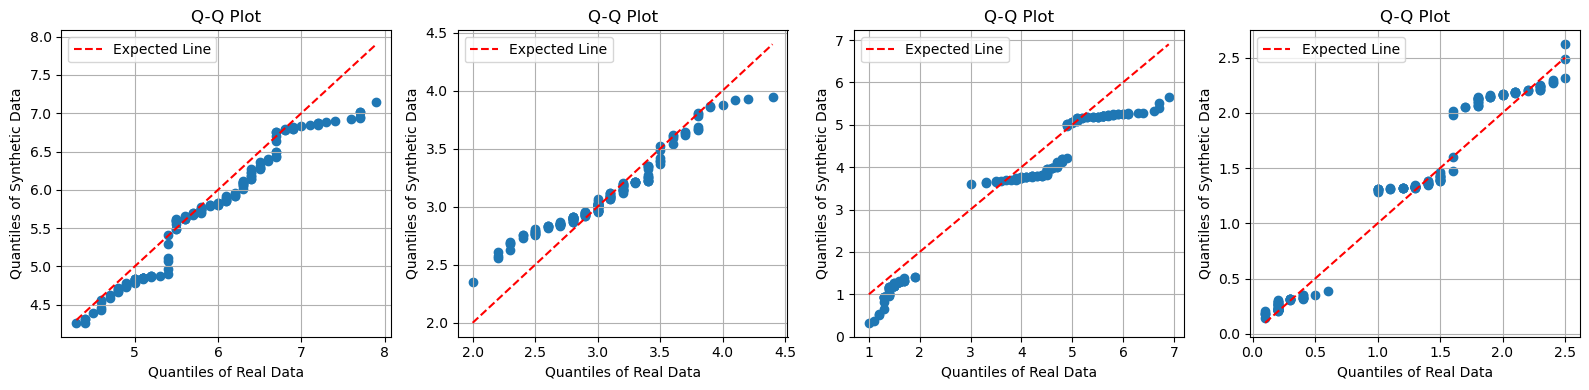

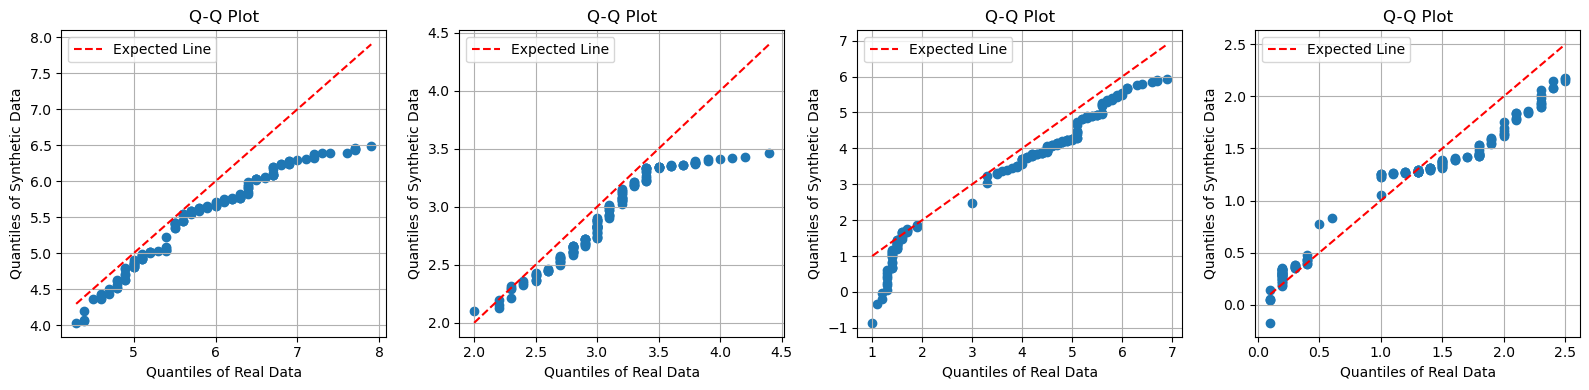

In [36]:
nv2_df = data_dict['dataframe'][0]
nv16_df = data_dict['dataframe'][3]

for dataframe in [nv2_df, nv16_df]:
    utils.plot_quantiles(real_iris, dataframe)

Let's plot both dataframes.

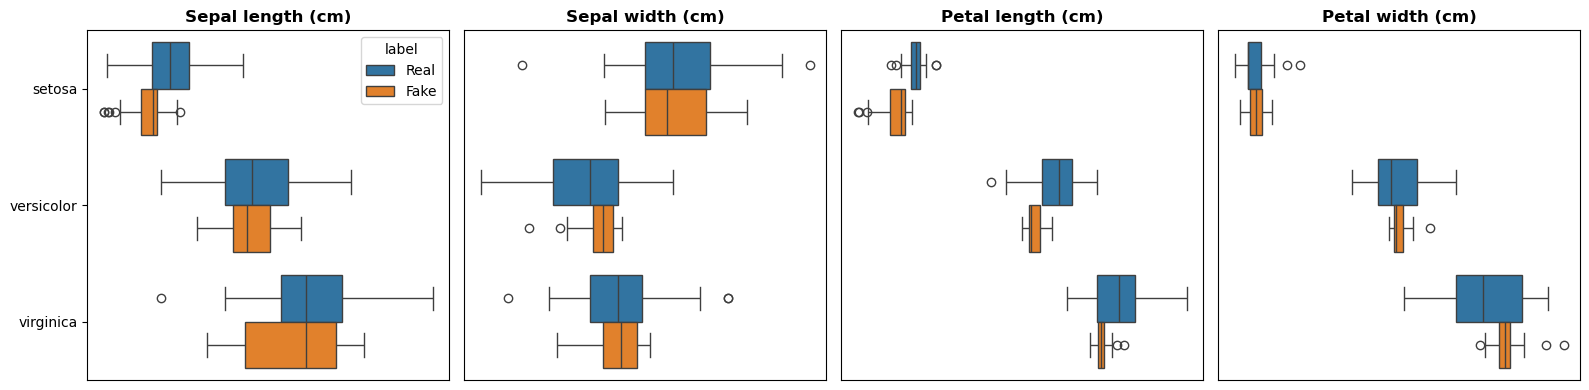

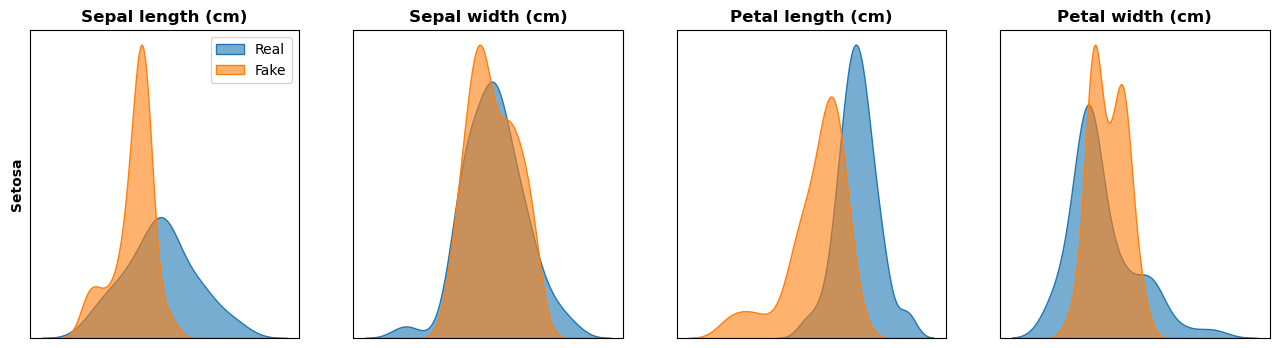

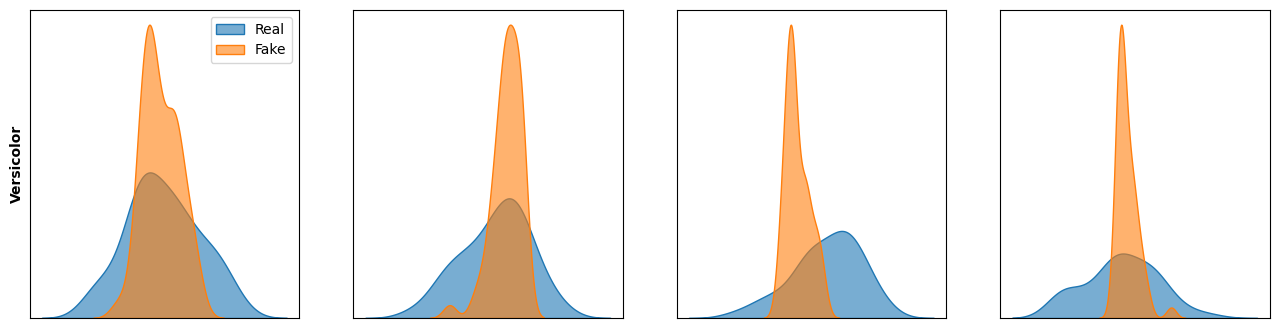

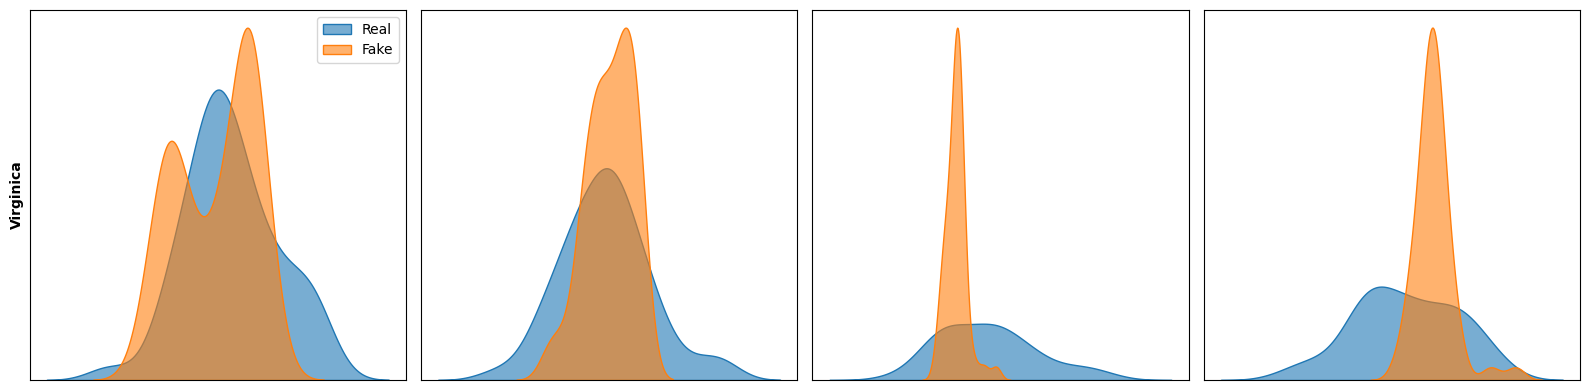

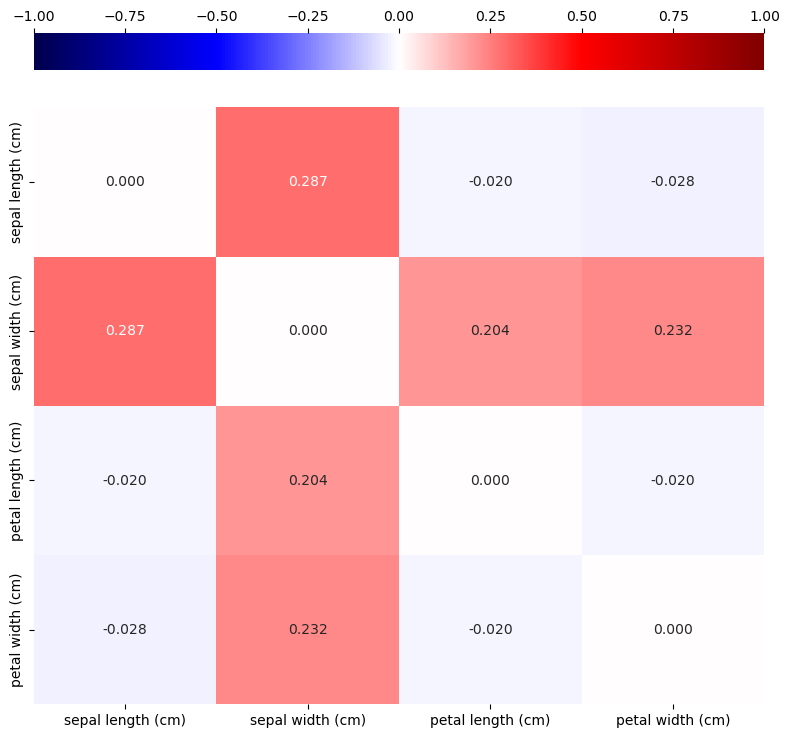

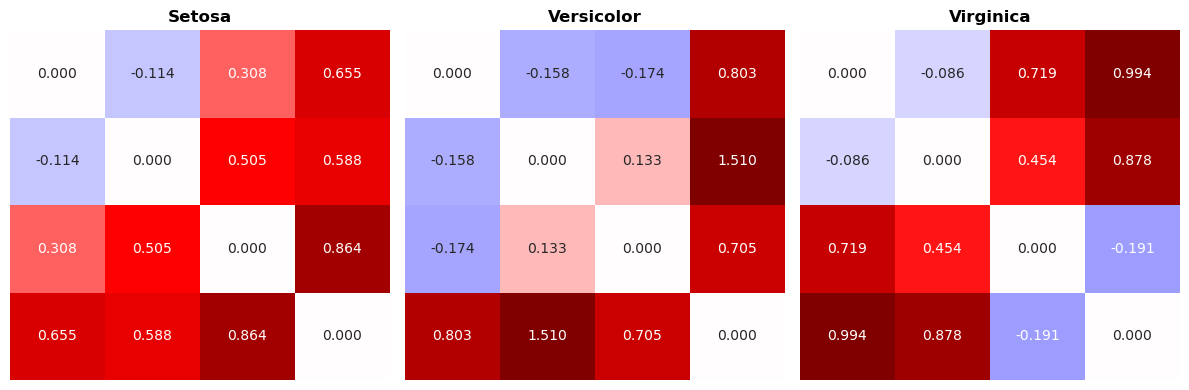

In [37]:
utils.plot_data(real_iris, 'target', nv2_df)

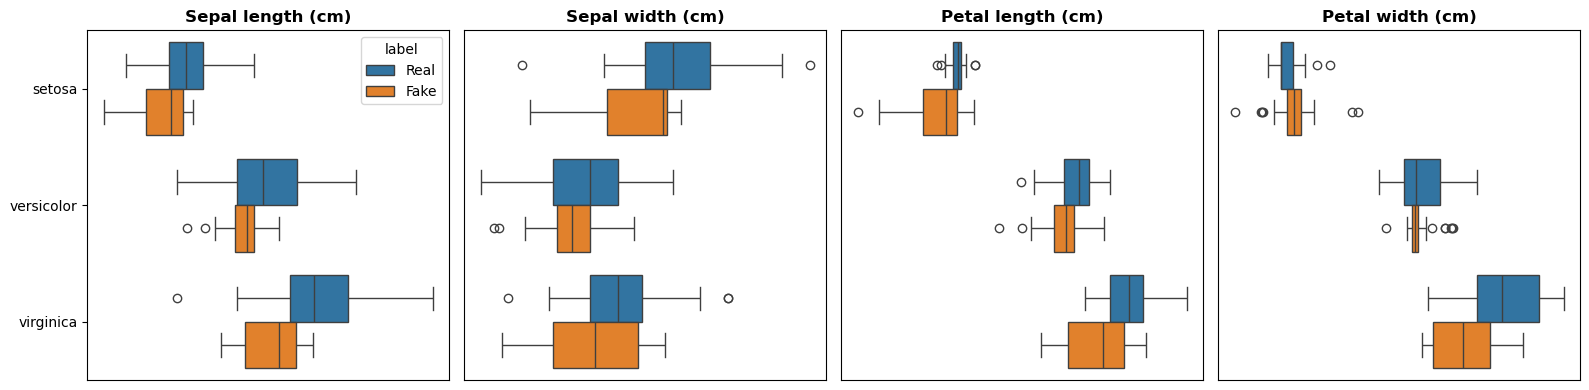

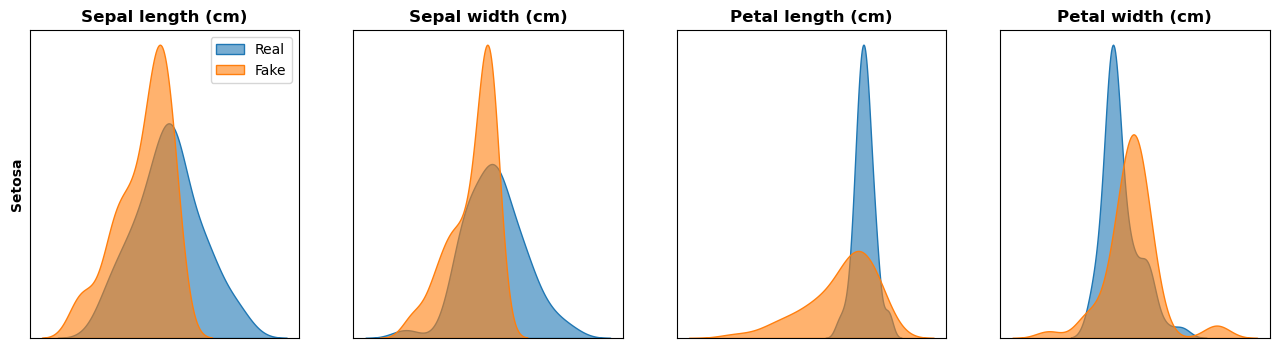

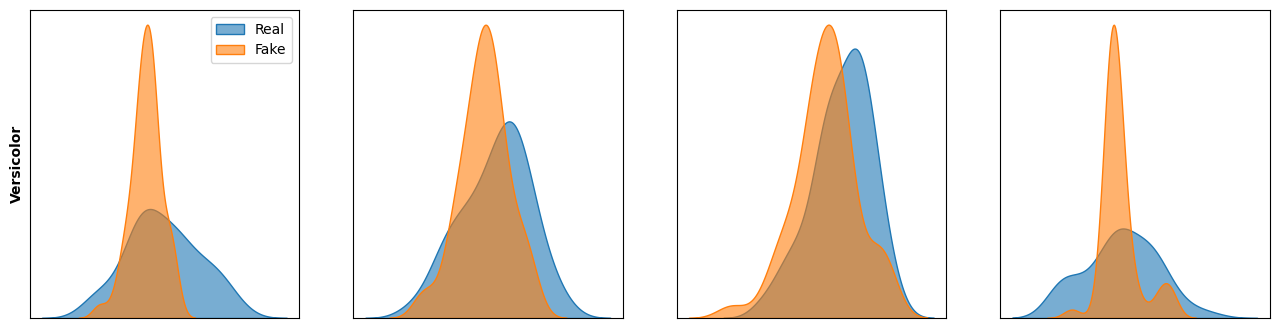

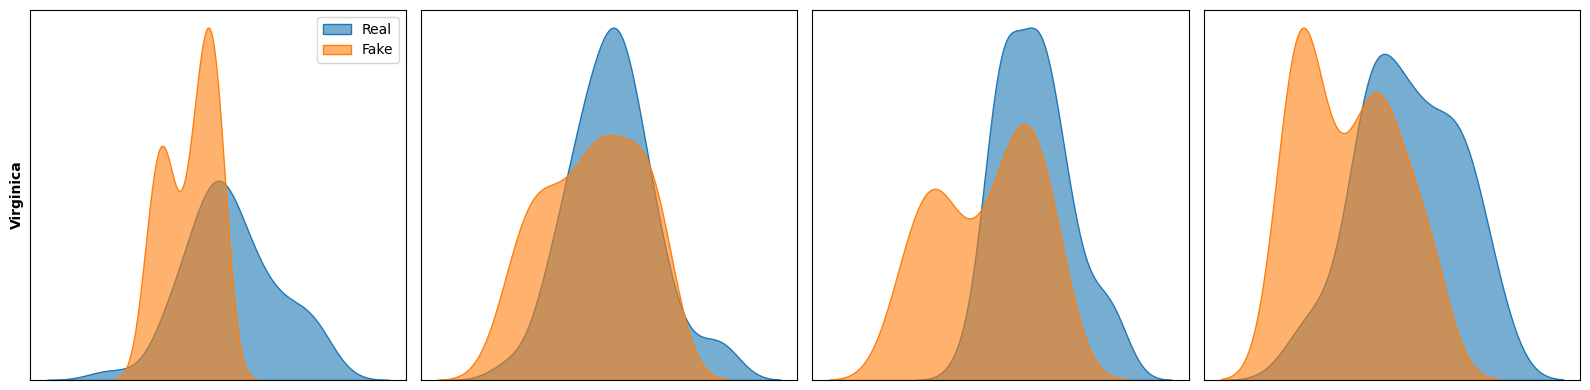

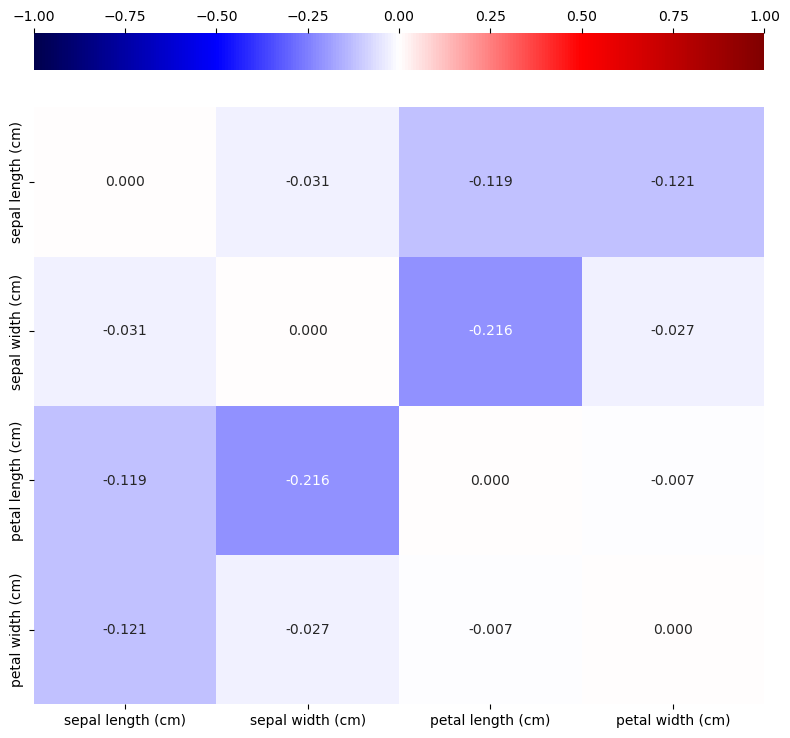

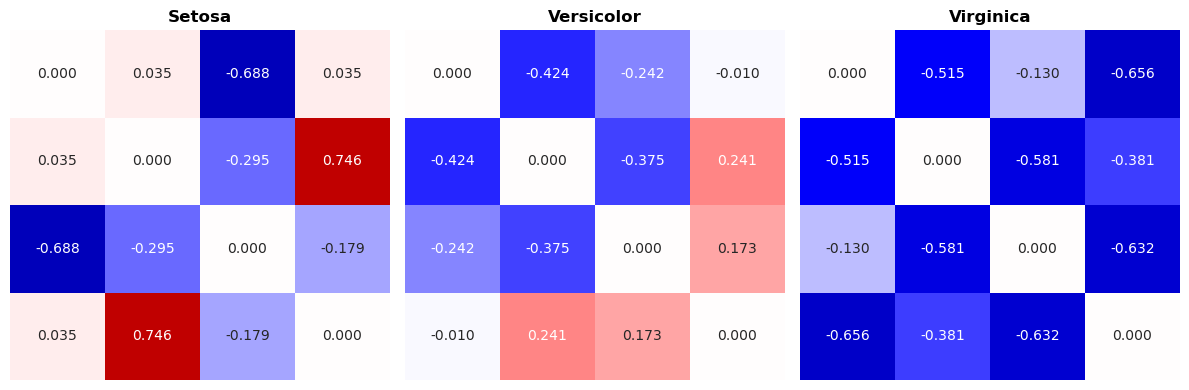

In [38]:
utils.plot_data(real_iris, 'target', nv16_df)

Let's check differences between correlations.

In [39]:
print((real_iris.select_dtypes('number').corr().sum() - nv2_df.select_dtypes('number').corr().sum()).sum())
print((real_iris.select_dtypes('number').corr().sum() - nv16_df.select_dtypes('number').corr().sum()).sum())

1.3094255686505512
-1.0409052261061076


We must draw an important conclusion:
1. According to the KS test at the same architecture size 2 noise vector is the best.
2. Wasserstein's distance leads us to the same conclusion.
3. Q-Q plots are more difficult to interpret, in fact they show similar performance overall.
4. Graphically we see how by using a larger latent information representation, **a noise vector of size 16**, we are better able to reproduce specific class distributions as well as correlations.

Although this dataset is very simple a noise vector that is too small would not allow us to adequately capture the relationships among the variables. therefore we will use a latent representation of dimension 16.

The next steps will involve refining the model to achieve even better performance.

## Fine Tuning the CGAN
First of all let's set a new class for our GAN nets using the best noise vector size.

In [40]:
noise_dim = 16

class Generator(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 4),
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x
    
class Discriminator(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
            
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x

gen = Generator(input_dim = noise_dim, num_classes = 3)
disc = Discriminator(input_dim = 4, num_classes = 3)

print(f'Generator parameters: {sum(p.numel() for p in gen.parameters())/1000}k')
print(f'Discriminator parameters: {sum(p.numel() for p in disc.parameters())/1000}k')

Generator parameters: 13.501k
Discriminator parameters: 11.914k


It is well known that neural networks perform best when they exploit large amounts of data; having no additional data to train the model we can approach the problem from another perspective by performing feature engeeneering to increase the complexity of the task.

Taking advantage of Samy Baladram's work we will create some features of his [Iris Extended Dataset](https://www.kaggle.com/datasets/samybaladram/iris-dataset-extended).

Specifically:
$$ \text{Sepal Area} \rightarrow \text{Sepal Length} \times \text{Sepal Width} $$

$$ \text{Petal Area} \rightarrow \text{Petal Length} \times \text{Petal Width} $$

$$ \text{Sepal Aspect Ratio} \rightarrow \frac{\text{Sepal Length}}{\text{Sepal Width}} $$

$$ \text{Petal Aspect Ratio} \rightarrow \frac{\text{Petal Length}}{\text{Petal Width}} $$

$$ \text{Sepal to Petal Length Ratio} \rightarrow \frac{\text{Sepal Length}}{\text{Petal Length}} $$

$$ \text{Sepal to Petal Width Ratio} \rightarrow \frac{\text{Sepal Width}}{\text{Petal Width}} $$

$$ \text{Sepal Petal Length Difference} \rightarrow \text{Sepal Length} - \text{Petal Length} $$

$$ \text{Sepal Petal Width Difference} \rightarrow \text{Sepal Width} - \text{Petal Width} $$

In [41]:
aug_iris = real_iris.copy()

aug_iris['sepal area'] = aug_iris['sepal length (cm)'] * aug_iris['sepal width (cm)']
aug_iris['petal area'] = aug_iris['petal length (cm)'] * aug_iris['petal width (cm)']
aug_iris['sepal aspect ratio'] = aug_iris['sepal length (cm)'] / aug_iris['sepal width (cm)']
aug_iris['petal aspect ratio'] = aug_iris['petal length (cm)'] / aug_iris['petal width (cm)']
aug_iris['sepal petal length ratio'] = aug_iris['sepal length (cm)'] / aug_iris['petal length (cm)']
aug_iris['sepal petal width ratio'] = aug_iris['sepal width (cm)'] / aug_iris['petal width (cm)']
#aug_iris['sepal petal length diff'] = aug_iris['sepal length (cm)'] - aug_iris['petal length (cm)']
#aug_iris['sepal petal width diff'] = aug_iris['sepal width (cm)'] - aug_iris['petal width (cm)']

target_column = aug_iris.pop('target')
aug_iris['target'] = target_column
aug_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),sepal area,petal area,sepal aspect ratio,petal aspect ratio,sepal petal length ratio,sepal petal width ratio,target
0,5.1,3.5,1.4,0.2,17.85,0.28,1.457143,7.000000,3.642857,17.500000,setosa
1,4.9,3.0,1.4,0.2,14.70,0.28,1.633333,7.000000,3.500000,15.000000,setosa
2,4.7,3.2,1.3,0.2,15.04,0.26,1.468750,6.500000,3.615385,16.000000,setosa
3,4.6,3.1,1.5,0.2,14.26,0.30,1.483871,7.500000,3.066667,15.500000,setosa
4,5.0,3.6,1.4,0.2,18.00,0.28,1.388889,7.000000,3.571429,18.000000,setosa
...,...,...,...,...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,20.10,11.96,2.233333,2.260870,1.288462,1.304348,virginica
146,6.3,2.5,5.0,1.9,15.75,9.50,2.520000,2.631579,1.260000,1.315789,virginica
147,6.5,3.0,5.2,2.0,19.50,10.40,2.166667,2.600000,1.250000,1.500000,virginica
148,6.2,3.4,5.4,2.3,21.08,12.42,1.823529,2.347826,1.148148,1.478261,virginica


Now we have to preprocess the new real data.

In [42]:
X_aug, y = aug_iris.select_dtypes('number'), y

aug_std_scl = StandardScaler()
X_aug_scld = aug_std_scl.fit_transform(X_aug)

aug_gan_dataset = IrisDataset(X_aug_scld, y)
aug_gan_dataloader = DataLoader(aug_gan_dataset, batch_size = 32, shuffle= True)

for batch in aug_gan_dataloader:
    gan_batch = batch
    break
    
print(gan_batch[0].shape)
print(gan_batch[1].shape)

torch.Size([32, 10])
torch.Size([32])


Now let's check new GAN's models dimensions.

In [43]:
noise_dim = 16
data_dim = aug_iris.select_dtypes('number').shape[1]

class Generator(nn.Module):
    def __init__(self, input_dim, num_classes, output_dim):
        super().__init__()
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, output_dim),
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x
    
class Discriminator(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
            
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x

set_seed()    
gen = Generator(input_dim = noise_dim, num_classes = 3, output_dim = data_dim)
disc = Discriminator(input_dim = data_dim, num_classes = 3)

print(f'Generator parameters: {sum(p.numel() for p in gen.parameters())/1000}k')
print(f'Discriminator parameters: {sum(p.numel() for p in disc.parameters())/1000}k')

Generator parameters: 13.603k
Discriminator parameters: 12.682k


The difference is still the same; it will be the data generated that will give us an idea of the usefulness of this addition.

In [44]:
g_opt = torch.optim.Adam(gen.parameters(), lr = 1e-3)
d_opt = torch.optim.Adam(disc.parameters(), lr = 1e-3)

criterion = nn.BCELoss()

set_seed()
z = torch.randn(150, noise_dim)

In [45]:
for epoch in tqdm(range(5001), desc = 'Training Conditional GAN'):
    
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    
    disc.train()
    gen.train()
    
    for data, labels in aug_gan_dataloader:
        
        real_data = data
        real_labels = torch.ones(real_data.shape[0], 1)
        
        train_z = torch.randn(real_data.shape[0], noise_dim)
        fake_data = gen(train_z, labels)
        fake_labels = torch.zeros(real_data.shape[0], 1)
        
        disc.zero_grad()
        
        real_loss = criterion(disc(real_data, labels), real_labels)
        fake_loss = criterion(disc(fake_data.detach(), labels), fake_labels)
        d_loss = (real_loss + fake_loss) / 2
        disc_epoch_loss += d_loss.item()
        d_loss.backward()
        
        d_opt.step()
        
        gen.zero_grad()
        
        gen_labels = torch.ones(real_data.shape[0], 1)
        
        g_loss = criterion(disc(fake_data, labels), gen_labels)
        gen_epoch_loss += g_loss.item()
        g_loss.backward()
        
        g_opt.step()
        
    g_epoch_loss = gen_epoch_loss/len(real_gan_dataloader)
    d_epoch_loss = disc_epoch_loss/len(real_gan_dataloader)
    
    if epoch % 500 == 0 or epoch == 5000:
        
        print(f'\nEpoch {epoch}/500 | DLoss: {d_epoch_loss:.4f} | GLoss {g_epoch_loss:.4f}')
        with torch.no_grad():
            gen.eval()
            gen_z = gen(z, real_gan_dataloader.dataset.label)
            utils.compare_results(aug_gan_dataloader.dataset.data, gen_z)

Training Conditional GAN:   0%|          | 0/5001 [00:00<?, ?it/s]


Epoch 0/500 | DLoss: 0.6877 | GLoss 0.6674
MEAN: [ 0.118  0.022 -0.156  0.062 -0.054 -0.281  0.03  -0.101  0.108 -0.023]
STD:  [0.988 0.99  0.989 0.992 0.99  0.992 0.991 0.989 0.989 0.99 ]
MIN:  [-1.715 -2.381 -1.681 -1.358 -2.367 -1.46  -1.664 -0.938 -0.775 -0.679]
MAX:  [2.571 3.071 1.6   1.745 3.54  1.843 2.517 4.178 2.731 4.278]
SKEW: [ 0.331 -0.271 -0.031 -0.2   -0.336  0.757 -0.237  2.827  0.43   1.804]
KURT: [-3.170e-01  2.000e-03 -1.236e+00 -1.114e+00  3.590e-01 -8.630e-01
 -3.370e-01  5.445e+00 -7.180e-01  3.044e+00]

Epoch 500/500 | DLoss: 0.4542 | GLoss 1.2383
MEAN: [-0.092 -0.226  0.14   0.195 -0.211  0.318  0.06  -0.001 -0.032 -0.179]
STD:  [-0.076  0.023 -0.253 -0.036  0.166 -0.311 -0.006  0.195 -0.147 -0.01 ]
MIN:  [ 0.216  0.736  1.26   0.853 -0.311  1.878  0.298 -0.095  0.086 -0.017]
MAX:  [0.357 1.15  0.5   0.565 2.175 0.859 0.464 2.522 0.254 1.943]
SKEW: [0.903 0.994 0.499 0.535 1.305 1.005 0.475 1.31  0.086 0.896]
KURT: [ 0.343 -0.621 -0.308 -0.185  0.961 -0.214  0

In [46]:
fake_data = gen(z, real_gan_dataloader.dataset.label)
gan_df = pd.DataFrame(aug_std_scl.inverse_transform(fake_data.detach().numpy()))
gan_df['target'] = target_column
gan_df.columns = aug_iris.columns
gan_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),sepal area,petal area,sepal aspect ratio,petal aspect ratio,sepal petal length ratio,sepal petal width ratio,target
0,4.609581,3.709446,1.580484,0.110027,19.264391,-1.564529,1.231644,5.959449,2.997213,12.290586,setosa
1,4.484276,3.206043,1.613790,0.229174,15.163789,-1.534672,1.459352,7.326575,2.972477,14.171782,setosa
2,4.457926,3.272712,1.504358,0.197380,15.548547,-1.723330,1.404453,7.352727,3.034383,14.430820,setosa
3,4.156509,3.514025,1.757071,0.453412,16.802429,-0.160206,1.192333,5.063421,2.672872,10.414314,setosa
4,4.088163,3.204390,1.384282,0.238547,14.186530,-2.087553,1.317245,7.267244,2.946493,14.616728,setosa
...,...,...,...,...,...,...,...,...,...,...,...
145,6.857656,3.140471,6.460920,2.362500,21.492645,14.509140,2.143745,2.433655,0.894304,0.783703,virginica
146,6.496620,3.242965,6.022467,2.288767,21.354582,13.389585,1.956497,2.278317,0.931524,0.925314,virginica
147,7.582609,3.553399,7.164296,2.472193,26.522598,16.613768,2.096730,2.569672,0.844217,0.937873,virginica
148,4.777980,2.734199,4.915978,2.310885,13.496274,11.895844,1.757811,1.928265,1.150152,1.883084,virginica


In [47]:
gan_df = gan_df[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'target']]
gan_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,4.609581,3.709446,1.580484,0.110027,setosa
1,4.484276,3.206043,1.613790,0.229174,setosa
2,4.457926,3.272712,1.504358,0.197380,setosa
3,4.156509,3.514025,1.757071,0.453412,setosa
4,4.088163,3.204390,1.384282,0.238547,setosa
...,...,...,...,...,...
145,6.857656,3.140471,6.460920,2.362500,virginica
146,6.496620,3.242965,6.022467,2.288767,virginica
147,7.582609,3.553399,7.164296,2.472193,virginica
148,4.777980,2.734199,4.915978,2.310885,virginica


In [48]:
utils.describe_data(real_iris, 'target', gan_df)

REAL                      SYNTHETIC             \
                       setosa versicolor virginica    setosa versicolor   
MEAN sepal length (cm)  5.006      5.936     6.588     4.449      5.570   
     sepal width (cm)   3.428      2.770     2.974     3.352      2.880   
     petal length (cm)  1.462      4.260     5.552     1.719      4.117   
     petal width (cm)   0.246      1.326     2.026     0.302      1.394   
STD  sepal length (cm)  0.352      0.516     0.636     0.339      0.689   
     sepal width (cm)   0.379      0.314     0.322     0.244      0.179   
     petal length (cm)  0.174      0.470     0.552     0.187      0.490   
     petal width (cm)   0.105      0.198     0.275     0.159      0.113   
MIN  sepal length (cm)  4.300      4.900     4.900     3.682      4.319   
     sepal width (cm)   2.300      2.000     2.200     2.704      2.513   
     petal length (cm)  1.000      3.000     4.500     1.193      3.200   
     petal width (cm)   0.100      1.000     1.400     0.051      1.162   
MAX  sepal length (cm)  5.800      7.000     7.900     5.321      6.851   
     sepal width (cm)   4.400      3.400     3.800     3.769      3.382   
     petal length (cm)  1.900      5.100     6.900     2.127      4.998   
     petal width (cm)   0.600      1.800     2.500     0.912      1.779   
SKEW sepal length (cm)  0.116      0.102     0.114     0.559      0.010   
     sepal width (cm)   0.040     -0.352     0.355    -0.623      0.374   
     petal length (cm)  0.103     -0.588     0.533    -0.189     -0.067   
     petal width (cm)   1.216     -0.030    -0.126     1.230      0.748   
KURT sepal length (cm) -0.346     -0.599    -0.088     0.136     -0.825   
     sepal width (cm)   0.744     -0.448     0.520     0.351      0.846   
     petal length (cm)  0.805     -0.074    -0.256     0.050     -0.907   
     petal width (cm)   1.434     -0.488    -0.661     2.951      1.322   
IQR  sepal length (cm)  0.400      0.700     0.675     0.426      0.909   
     sepal width (cm)   0.475      0.475     0.375     0.263      0.161   
     petal length (cm)  0.175      0.600     0.775     0.258      0.753   
     petal width (cm)   0.100      0.300     0.500     0.209      0.149   

                                  
                       virginica  
MEAN sepal length (cm)     6.045  
     sepal width (cm)      3.061  
     petal length (cm)     5.694  
     petal width (cm)      2.231  
STD  sepal length (cm)     0.909  
     sepal width (cm)      0.189  
     petal length (cm)     0.845  
     petal width (cm)      0.145  
MIN  sepal length (cm)     4.308  
     sepal width (cm)      2.679  
     petal length (cm)     4.322  
     petal width (cm)      1.969  
MAX  sepal length (cm)     8.255  
     sepal width (cm)      3.553  
     petal length (cm)     7.979  
     petal width (cm)      2.562  
SKEW sepal length (cm)     0.226  
     sepal width (cm)      0.542  
     petal length (cm)     0.589  
     petal width (cm)      0.289  
KURT sepal length (cm)    -0.543  
     sepal width (cm)      0.198  
     petal length (cm)    -0.388  
     petal width (cm)     -0.767  
IQR  sepal length (cm)     1.293  
     sepal width (cm)      0.194  
     petal length (cm)     1.311  
     petal width (cm)      0.219

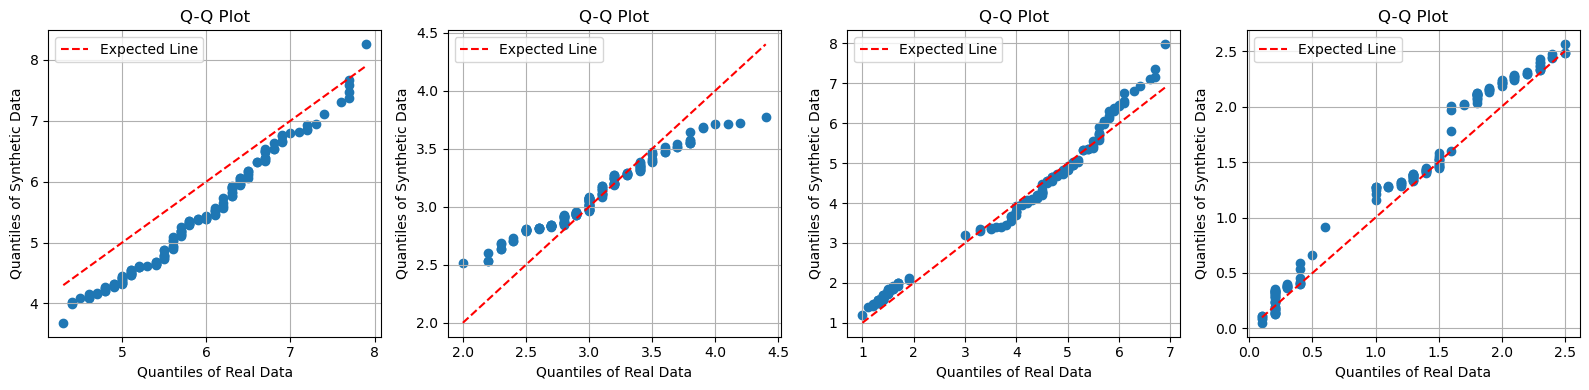

In [49]:
utils.plot_quantiles(real_iris.select_dtypes('number'), gan_df.select_dtypes('number'))

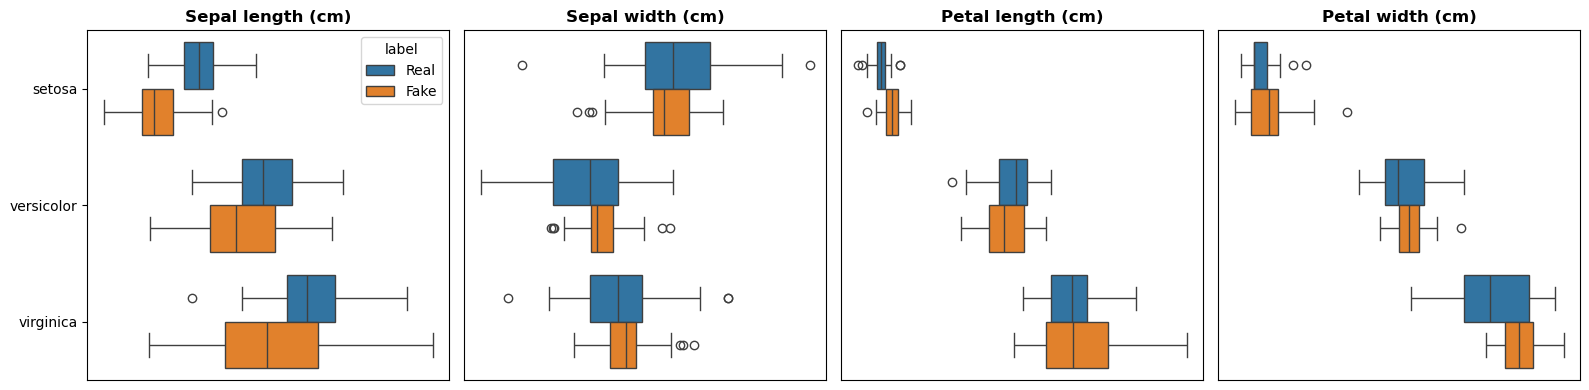

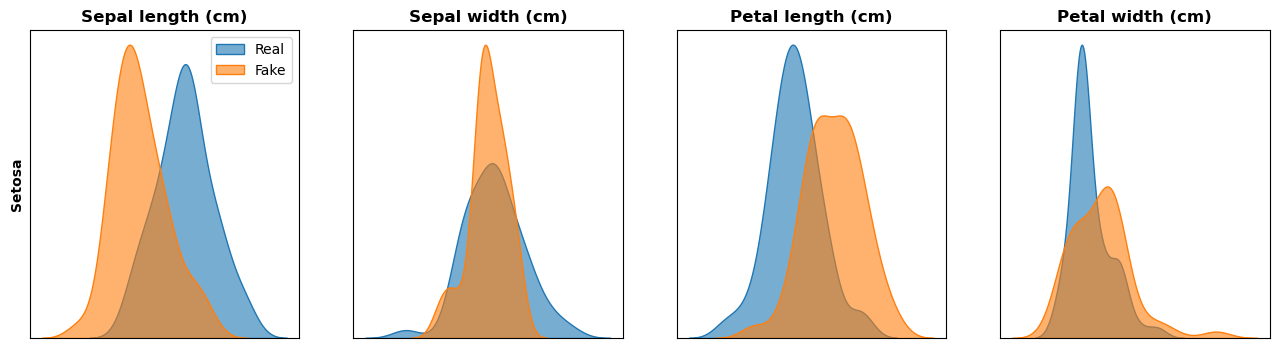

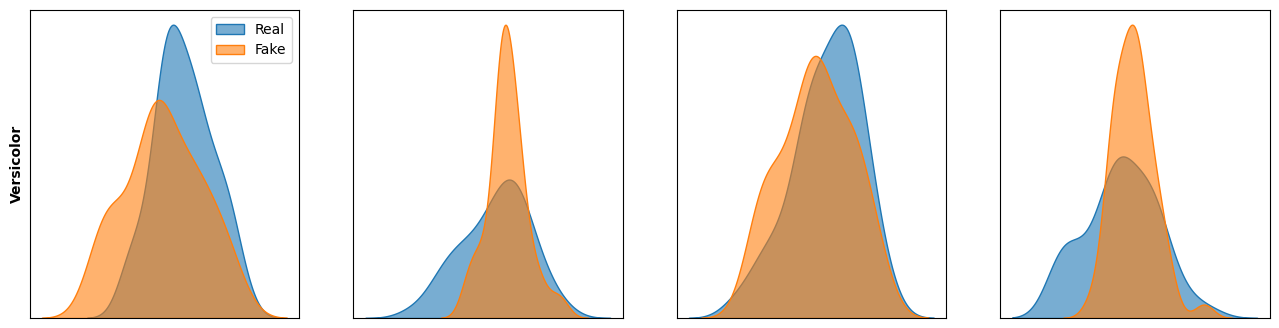

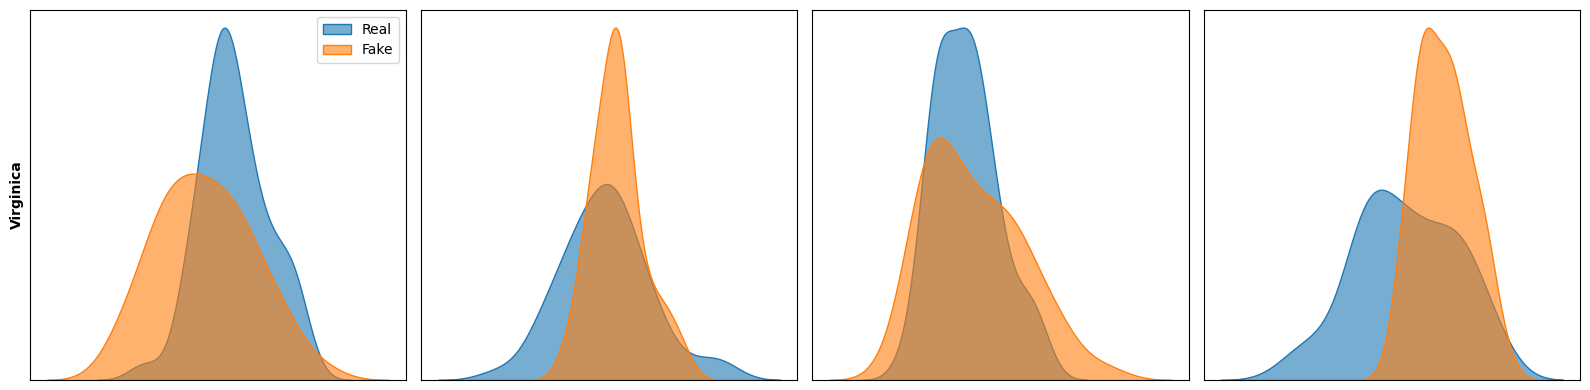

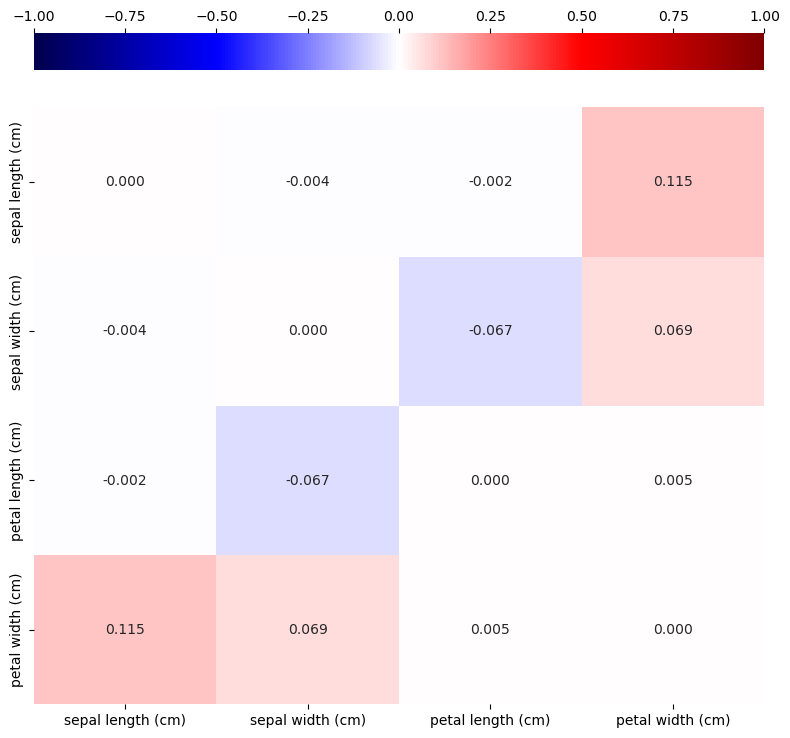

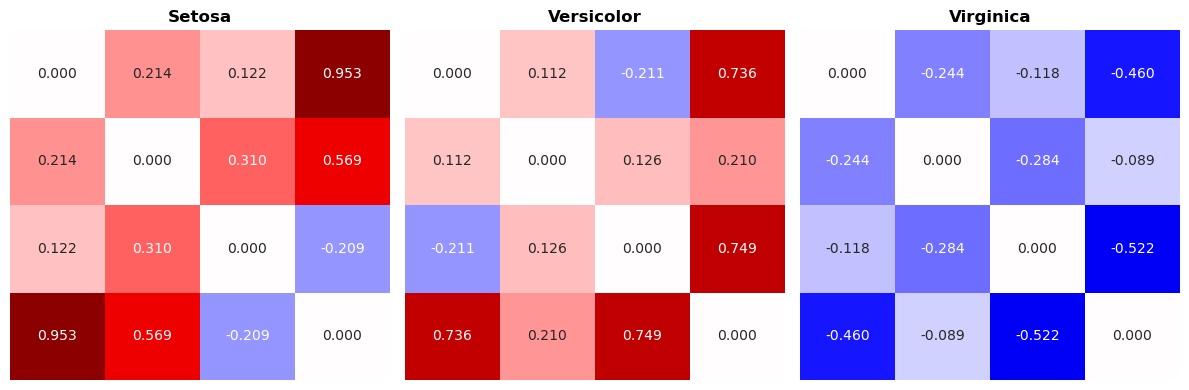

In [50]:
utils.plot_data(real_iris, 'target', gan_df)

In [51]:
utils.calculate_ks_test(real_iris, gan_df).style.background_gradient(cmap = 'Reds')

,Feature,KS Statistic,P-Value
0,sepal length (cm),0.306667,0.000001
1,sepal width (cm),0.220000,0.001358
2,petal length (cm),0.213333,0.002106
3,petal width (cm),0.173333,0.021903


In [52]:
utils.calculate_wasserstein_distance(real_iris, gan_df).style.background_gradient(cmap = 'Reds')

,Feature,W Distance
0,sepal length (cm),0.493631
1,sepal width (cm),0.120075
2,petal length (cm),0.224072
3,petal width (cm),0.119264
